[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/saulventura/CS-7641-Assignment1/blob/master/LoanEligibility.ipynb)
  
    

# Project:

Predict Loan Eligibility for Dream Housing Finance company
Dream Housing Finance company deals in all kinds of home loans. They have presence across all urban, semi urban and rural areas. Customer first applies for home loan and after that company validates the customer eligibility for loan.

Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have provided a dataset to identify the customers segments that are eligible for loan amount so that they can specifically target these customers. 


# Loan Eligibility 
<img src="loan.jpg" width="100%" height="100%"/>

In [195]:
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
%matplotlib inline
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from IPython.display import Markdown, display
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, classification_report, accuracy_score


import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-info">
<b><h1>1. Data Collection</h1></div>
</a><a class="anchor" id="exploration"></a>

In [2]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [3]:
train_orig = pd.read_csv('Loandataset.csv')

In [4]:
train_orig.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
train_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [6]:
train_orig.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


<div class="alert alert-block alert-info">
<b><h1>2. Data Preparation</h1></div>
</a><a class="anchor" id="exploration"></a>

Let's assing original dataframes to new ones.

In [7]:
train = train_orig

Renaming column labels when they contain blank spaces or any special character


In [8]:
def rename_column_labels(df, old_str = " ", new_str = "_"):
    """Rename column names to avoid special characters or blank spaces.
           Parameters:
               df (dataframe): The dataframe whose columns's names will be evaluated
               old_str (str): The character from the column's names to be replaced
               new_str (str): The character that will replace 'old_str'
            Returns:
               df (dataframe): The input dataframe with the columns renamed
    """
    display(Markdown('**Results:**' ))
    cols = df.loc[:,df.columns.str.contains(old_str)].shape[1]
    if cols > 0:
        print("Features changed => {0}".format(cols))
        display(df.loc[:,df.columns.str.contains(old_str)].columns.values)
        df.columns = [label.replace(old_str, new_str ) for label in df.columns]
    else:
        print("No changes were applied")
    return df

In [9]:
train = rename_column_labels(train)

**Results:**

No changes were applied


**4.1 Remove Columns/Rows**


<strong>Let's check what columns are indexes.</strong>

In [10]:
def list_index_columns(df):
    display(Markdown('**Results:**' ))
    for col in df.columns[0:]:
        if df[col].nunique() == len(df):
            print(f"{col.ljust(25)}" +  ' ==> Datatype: ' + str(df[col].dtypes) )

In [11]:
list_index_columns(train)

**Results:**

Loan_ID                   ==> Datatype: object


<strong>Let's do a quick review of list of values per each column.</strong>


In [12]:
def list_column_values(df, number_of_values, print_all):
    display(Markdown('**Results:**' ))
    for col in df.columns[0:]:
        if df[col].nunique() <= number_of_values:
            print(f"{col.ljust(25)}" +  ' ==> ' + str(df[col].sort_values().unique().tolist()) )
        else:  
            if print_all=='True':
               print(f"{col.ljust(25)}" + ' ==> more than ' + str(number_of_values) + ' values')

In [13]:
list_column_values(train,10,'False')

**Results:**

Gender                    ==> ['Female', 'Male', nan]
Married                   ==> ['No', 'Yes', nan]
Dependents                ==> ['0', '1', '2', '3+', nan]
Education                 ==> ['Graduate', 'Not Graduate']
Self_Employed             ==> ['No', 'Yes', nan]
Loan_Amount_Term          ==> [12.0, 36.0, 60.0, 84.0, 120.0, 180.0, 240.0, 300.0, 360.0, 480.0, nan]
Credit_History            ==> [0.0, 1.0, nan]
Property_Area             ==> ['Rural', 'Semiurban', 'Urban']
Loan_Status               ==> ['N', 'Y']


In [14]:
def list_column_values_percentage(df, number_of_values):
    display(Markdown('**Results:**' ))
    print('Columns with less than ' + str(number_of_values) + ' values')
    for col in df.columns[0:]:
        if train[col].nunique() <= number_of_values:
            print(df[col].value_counts()/len(train)) 

In [15]:
list_column_values_percentage(train,3)

**Results:**

Columns with less than 3 values
Male      0.796417
Female    0.182410
Name: Gender, dtype: float64
Yes    0.648208
No     0.346906
Name: Married, dtype: float64
Graduate        0.781759
Not Graduate    0.218241
Name: Education, dtype: float64
No     0.814332
Yes    0.133550
Name: Self_Employed, dtype: float64
1.0    0.773616
0.0    0.144951
Name: Credit_History, dtype: float64
Semiurban    0.379479
Urban        0.328990
Rural        0.291531
Name: Property_Area, dtype: float64
Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64


In [16]:
def remove_column_values(df, columns_to_remove):
    display(Markdown('**Results:**'))
    print("Original number of features => {}".format(df.shape[1]))
    df = df.drop(columns_to_remove, axis=1)
    print("Number of features has been reduced to => {}".format(df.shape[1]))
    return df

** Let's remove column Loan ID **

In [17]:
train = remove_column_values(train,'Loan_ID')

**Results:**

Original number of features => 13
Number of features has been reduced to => 12


**Missing Values**

In [18]:
train.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [19]:
np.round(100*train.isnull().sum()/ len(train),2)

Gender               2.12
Married              0.49
Dependents           2.44
Education            0.00
Self_Employed        5.21
ApplicantIncome      0.00
CoapplicantIncome    0.00
LoanAmount           3.58
Loan_Amount_Term     2.28
Credit_History       8.14
Property_Area        0.00
Loan_Status          0.00
dtype: float64

In [20]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        display(Markdown('**Results:**'))
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [21]:
missing_values_table(train)

**Results:**

Your selected dataframe has 12 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
Credit_History,50,8.1
Self_Employed,32,5.2
LoanAmount,22,3.6
Dependents,15,2.4
Loan_Amount_Term,14,2.3
Gender,13,2.1
Married,3,0.5


<AxesSubplot:>

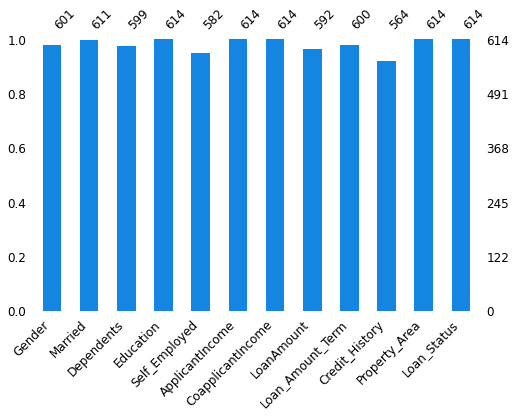

In [22]:
msno.bar(train, color = '#1585E2',fontsize=12,figsize = (8, 5))

<AxesSubplot:>

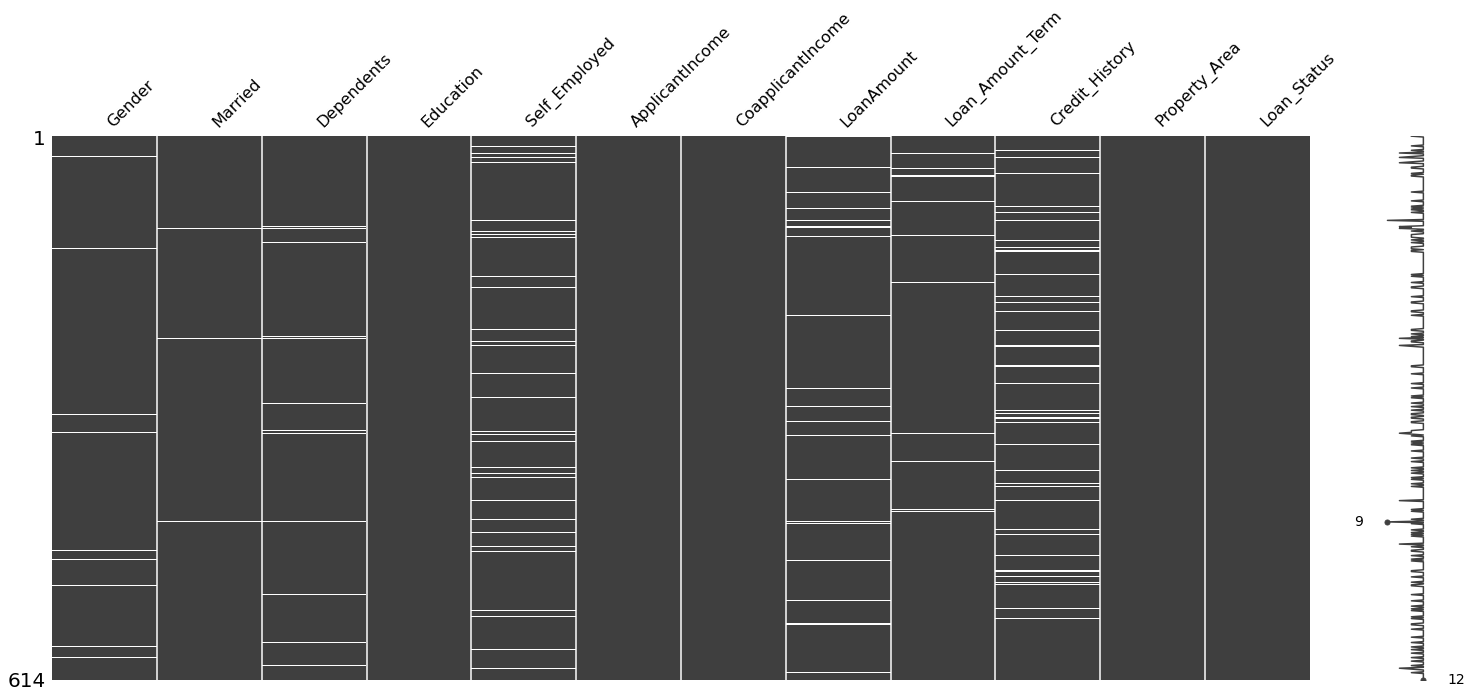

In [23]:
msno.matrix(train)


<AxesSubplot:>

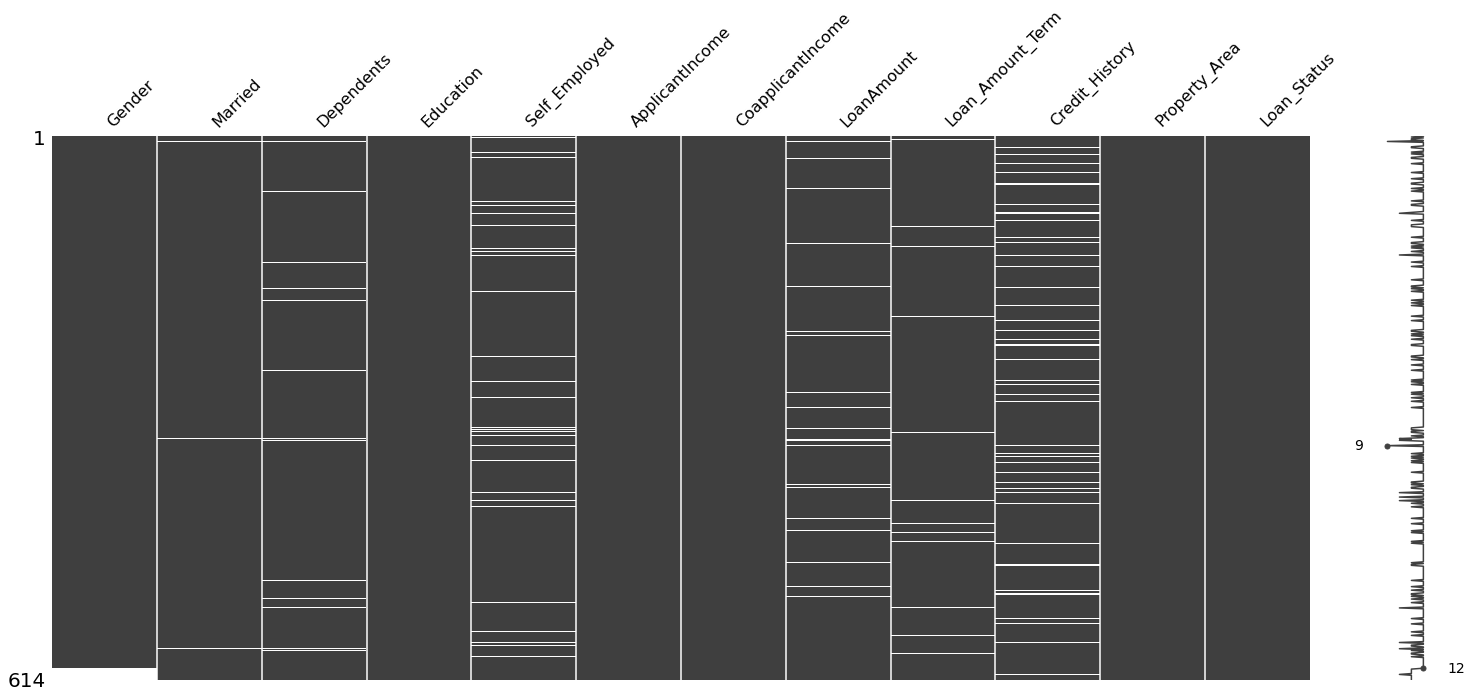

In [24]:
#sorted by gender
sorted = train.sort_values('Gender')
msno.matrix(sorted)

<AxesSubplot:>

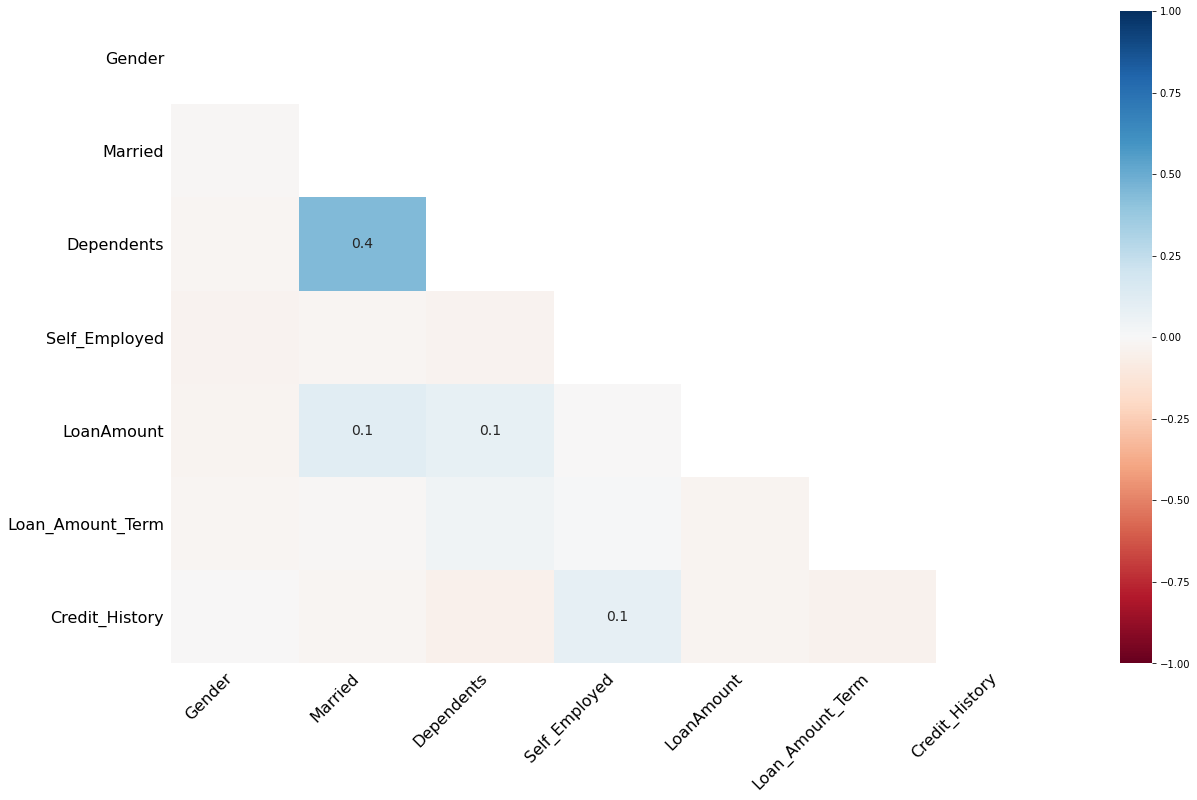

In [25]:
msno.heatmap(train)

<AxesSubplot:>

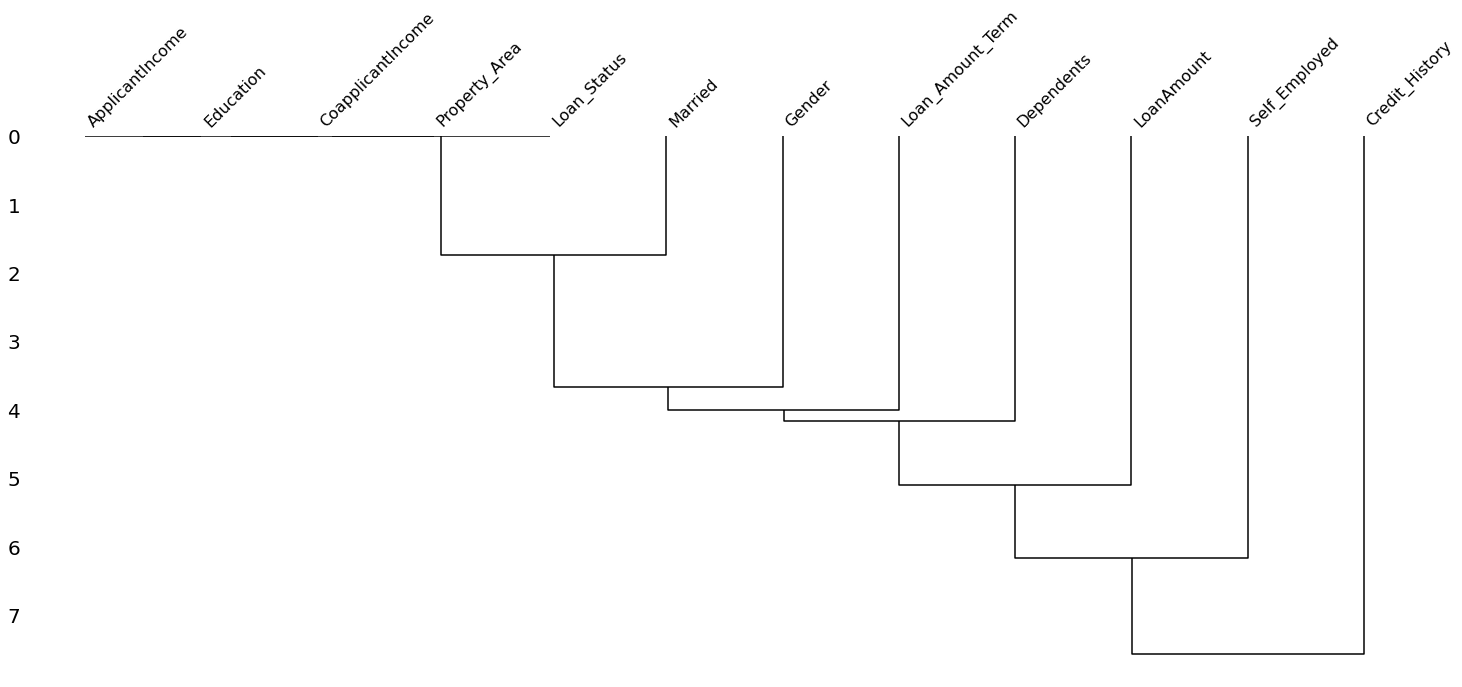

In [26]:
msno.dendrogram(train)

**Let's remove selected columns/rows with missing values.**

** Since there is no clear understanding/portion of missing columns, I don't plan to drop any columns from the list ** 

### Imputation

### New imputation technique: using regression model


<AxesSubplot:>

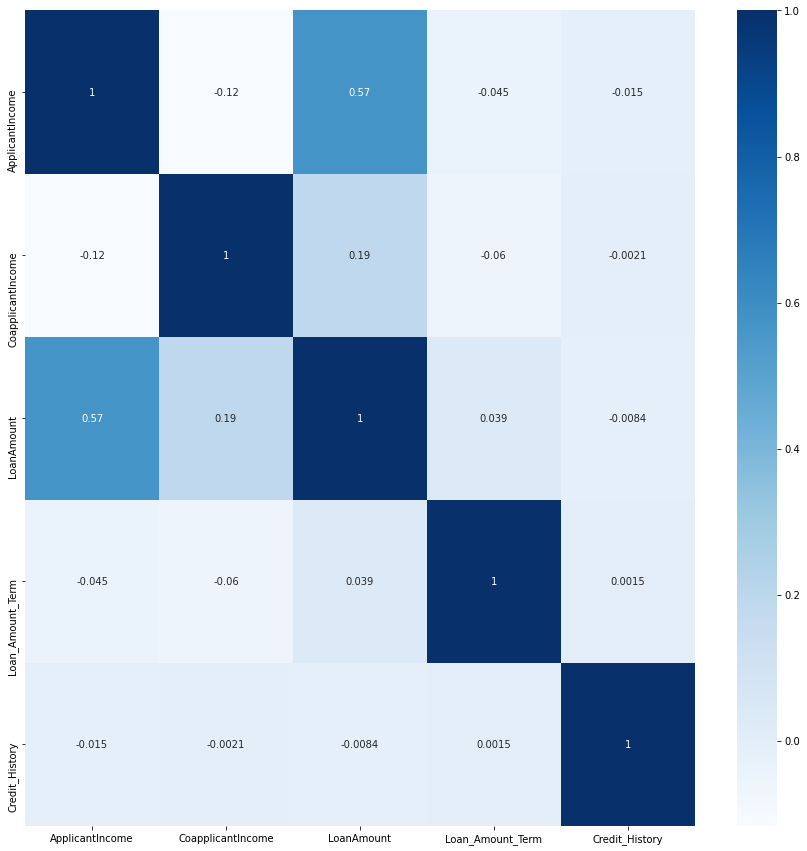

In [27]:
plt.subplots(figsize=(15,15))
data = train.corr()
sns.heatmap(data, cmap ='Blues', annot=True, annot_kws={"size": 10})

In [28]:
def regressor_inputer(df, output_column, input_column, decimals=2):
    
    display(Markdown('**Results:**'))
    #Missing values from Output column
    missing_output = df[output_column].isnull()
    print("Number of missing values in column: {} => {}".format(output_column,missing_output.sum() ))
    
    df_regressor = df.dropna(axis=0, subset = [output_column,input_column])
    df_regressor = df_regressor.loc[:,[output_column,input_column]]
    #Input column observations with Output column missing
    input_column_with_missing_output_column = pd.DataFrame(df[input_column][missing_output])
    input_column_with_missing_output_column = input_column_with_missing_output_column.dropna()
    #Creating regressor model
    x = df_regressor[[input_column]]
    y = df_regressor[[output_column]]
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)
    lm = LinearRegression().fit(x_train,y_train)
    print(f'R2 value in validation partition: {lm.score(x_val, y_val)}')
    #Predicting output column
    predictor = df[input_column][ df[output_column].isnull()  &  ~df[input_column].isnull() ] 
    predictor = pd.DataFrame(predictor)
    predictor[output_column]=  lm.predict( predictor[[input_column]] ) 
    df.loc[ df[output_column].isnull()  &  ~df[input_column].isnull() ,[output_column]] = predictor[output_column].round(decimals)
    print("New number of missing values in column: {} => {}".format(output_column, df[output_column].isnull().sum() ))
    return df
    #NOT CLEAR ON THIS FUNCTION 

In [29]:
train = regressor_inputer(train,'LoanAmount','ApplicantIncome',0)

**Results:**

Number of missing values in column: LoanAmount => 22
R2 value in validation partition: 0.17376718289912818
New number of missing values in column: LoanAmount => 0


In [30]:
missing_values_table(train)

**Results:**

Your selected dataframe has 12 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
Credit_History,50,8.1
Self_Employed,32,5.2
Dependents,15,2.4
Loan_Amount_Term,14,2.3
Gender,13,2.1
Married,3,0.5


<strong>Let's use mean/mode/median technique to impute missing values for column(s) identified in previous step.</strong>

In [31]:
mean_imputer = SimpleImputer(strategy='mean')
most_frequent_imputer = SimpleImputer(strategy='most_frequent')
median_imputer = SimpleImputer(strategy='median')

In [32]:
train["Credit_History"] = most_frequent_imputer.fit_transform(train[["Credit_History"]])
train["Self_Employed"] = most_frequent_imputer.fit_transform(train[["Self_Employed"]])
train["Dependents"] = most_frequent_imputer.fit_transform(train[["Dependents"]])
train["Loan_Amount_Term"] = most_frequent_imputer.fit_transform(train[["Loan_Amount_Term"]])
train["Gender"] = most_frequent_imputer.fit_transform(train[["Gender"]])
train["Married"] = most_frequent_imputer.fit_transform(train[["Married"]])

<strong>Now, let's check the missingness of the dataset.</strong>

In [33]:
missing_values_table(train)

**Results:**

Your selected dataframe has 12 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


 #### Transforming Columns

<strong>Let's review object columns.</strong>

In [34]:
print("Column data types and their frequency\n{}".format(train.dtypes.value_counts()))

Column data types and their frequency
object     7
float64    4
int64      1
dtype: int64


In [35]:
train.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [36]:
def check_object_columns(df):
    object_columns_df = df.select_dtypes(include=['object'])
    print(object_columns_df.iloc[0])
    i=0
    for col in object_columns_df:
        if is_numeric_dtype(df[col]):
            i+=1
            print(f"{col.ljust(25)}" + ' ==> is Numeric')
    if i==0:
        display(Markdown('**Results:**'))
        print('No numeric columns were found')

In [37]:
check_object_columns(train)

Gender               Male
Married                No
Dependents              0
Education        Graduate
Self_Employed          No
Property_Area       Urban
Loan_Status             Y
Name: 0, dtype: object


**Results:**

No numeric columns were found


** Let's convert columns **

In [38]:
def columns_to_numeric(df,columns_to_convert = []):
    display(Markdown('**Results:**'))
    for col in columns_to_convert:
        if col in df.columns:
            if is_numeric_dtype(df[col]):
                df[col] = df[col].str.rstrip('%').astype('float')
                print("Column {} was converted".format(col))
            else:
                print("Column {} could not be converted".format(col))
        else:
            print("Column {} does not exist".format(col))
    return df

In [39]:
train = columns_to_numeric(train,[])
# Not sure why giving error on float columns ==> it only applies to STRING columns with numeric values

**Results:**

<div class="alert alert-block alert-info">
<b><h1>3. Exploratory Data Analysis</h1></div>
</a><a class="anchor" id="exploration"></a>

EDA is the process of performing initial investigations on data so as to:

<li>Uncover underlying structure & patterns in the data
<li>Identify important variables
<li>Identify anomalies
<li>Test a hypothesis
<li>Check assumptions
<li>Set the stage for model development

Exploratory Data Analysis is like listening to what the data can tell us before we start the actual modeling process for a head start. 

** Let's do some data visualization! We'll use seaborn and pandas built-in plotting capabilities.**

Target column is assigned to l_target variable.

In [40]:
l_target = 'Loan_Status'

<div class="alert alert-block alert-warning">
<b>3.1 Univariate Analysis</b>
</div> </a><a class="anchor" id="univariate"></a>

<strong>Let's quick review target column values/distribution.</strong>

In [41]:
list_column_values_percentage(train,15)

**Results:**

Columns with less than 15 values
Male      0.81759
Female    0.18241
Name: Gender, dtype: float64
Yes    0.653094
No     0.346906
Name: Married, dtype: float64
0     0.586319
1     0.166124
2     0.164495
3+    0.083062
Name: Dependents, dtype: float64
Graduate        0.781759
Not Graduate    0.218241
Name: Education, dtype: float64
No     0.86645
Yes    0.13355
Name: Self_Employed, dtype: float64
360.0    0.856678
180.0    0.071661
480.0    0.024430
300.0    0.021173
84.0     0.006515
240.0    0.006515
120.0    0.004886
36.0     0.003257
60.0     0.003257
12.0     0.001629
Name: Loan_Amount_Term, dtype: float64
1.0    0.855049
0.0    0.144951
Name: Credit_History, dtype: float64
Semiurban    0.379479
Urban        0.328990
Rural        0.291531
Name: Property_Area, dtype: float64
Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64


In [42]:
def plot_target_column (df, target):
    ax = sns.countplot(x=target, data=df)
    plt.title('Distribution of ' + target + ' column')
    plt.xlabel('Frequency')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
    total = len(df[target])
    for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))
            ax.text(p.get_x()+p.get_width()/2., p.get_height() + 0.2, p.get_height(),ha="center")
    plt.show()

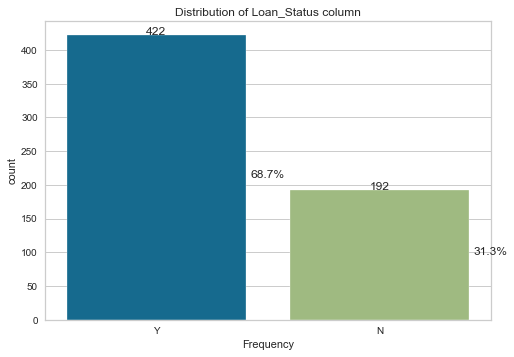

In [141]:
plot_target_column(train, l_target)

** Let's do again a quick review of list of values per each column **

In [44]:
list_column_values(train,15,'True')

**Results:**

Gender                    ==> ['Female', 'Male']
Married                   ==> ['No', 'Yes']
Dependents                ==> ['0', '1', '2', '3+']
Education                 ==> ['Graduate', 'Not Graduate']
Self_Employed             ==> ['No', 'Yes']
ApplicantIncome           ==> more than 15 values
CoapplicantIncome         ==> more than 15 values
LoanAmount                ==> more than 15 values
Loan_Amount_Term          ==> [12.0, 36.0, 60.0, 84.0, 120.0, 180.0, 240.0, 300.0, 360.0, 480.0]
Credit_History            ==> [0.0, 1.0]
Property_Area             ==> ['Rural', 'Semiurban', 'Urban']
Loan_Status               ==> ['N', 'Y']


**Let's plot categorical columns.**

In [45]:
def plot_categorical_columns(df):
    categorical = train.select_dtypes(exclude=['int', 'float']).columns
    lcols_in_plot = 2
    lrows_in_plot = math.ceil(len(categorical)/lcols_in_plot)   
    fig, ax = plt.subplots( lrows_in_plot, lcols_in_plot , figsize=(20, 30))
    plt.subplots_adjust(wspace=0.2, hspace=1) 
    sns.set(font_scale = 1.1)
    for variable, subplot in zip(categorical, ax.flatten()):
        sns.countplot(train[variable], ax=subplot)
        for label in subplot.get_xticklabels():
            label.set_rotation(45)
            label.set_ha("right")
            label.set_rotation_mode("anchor")

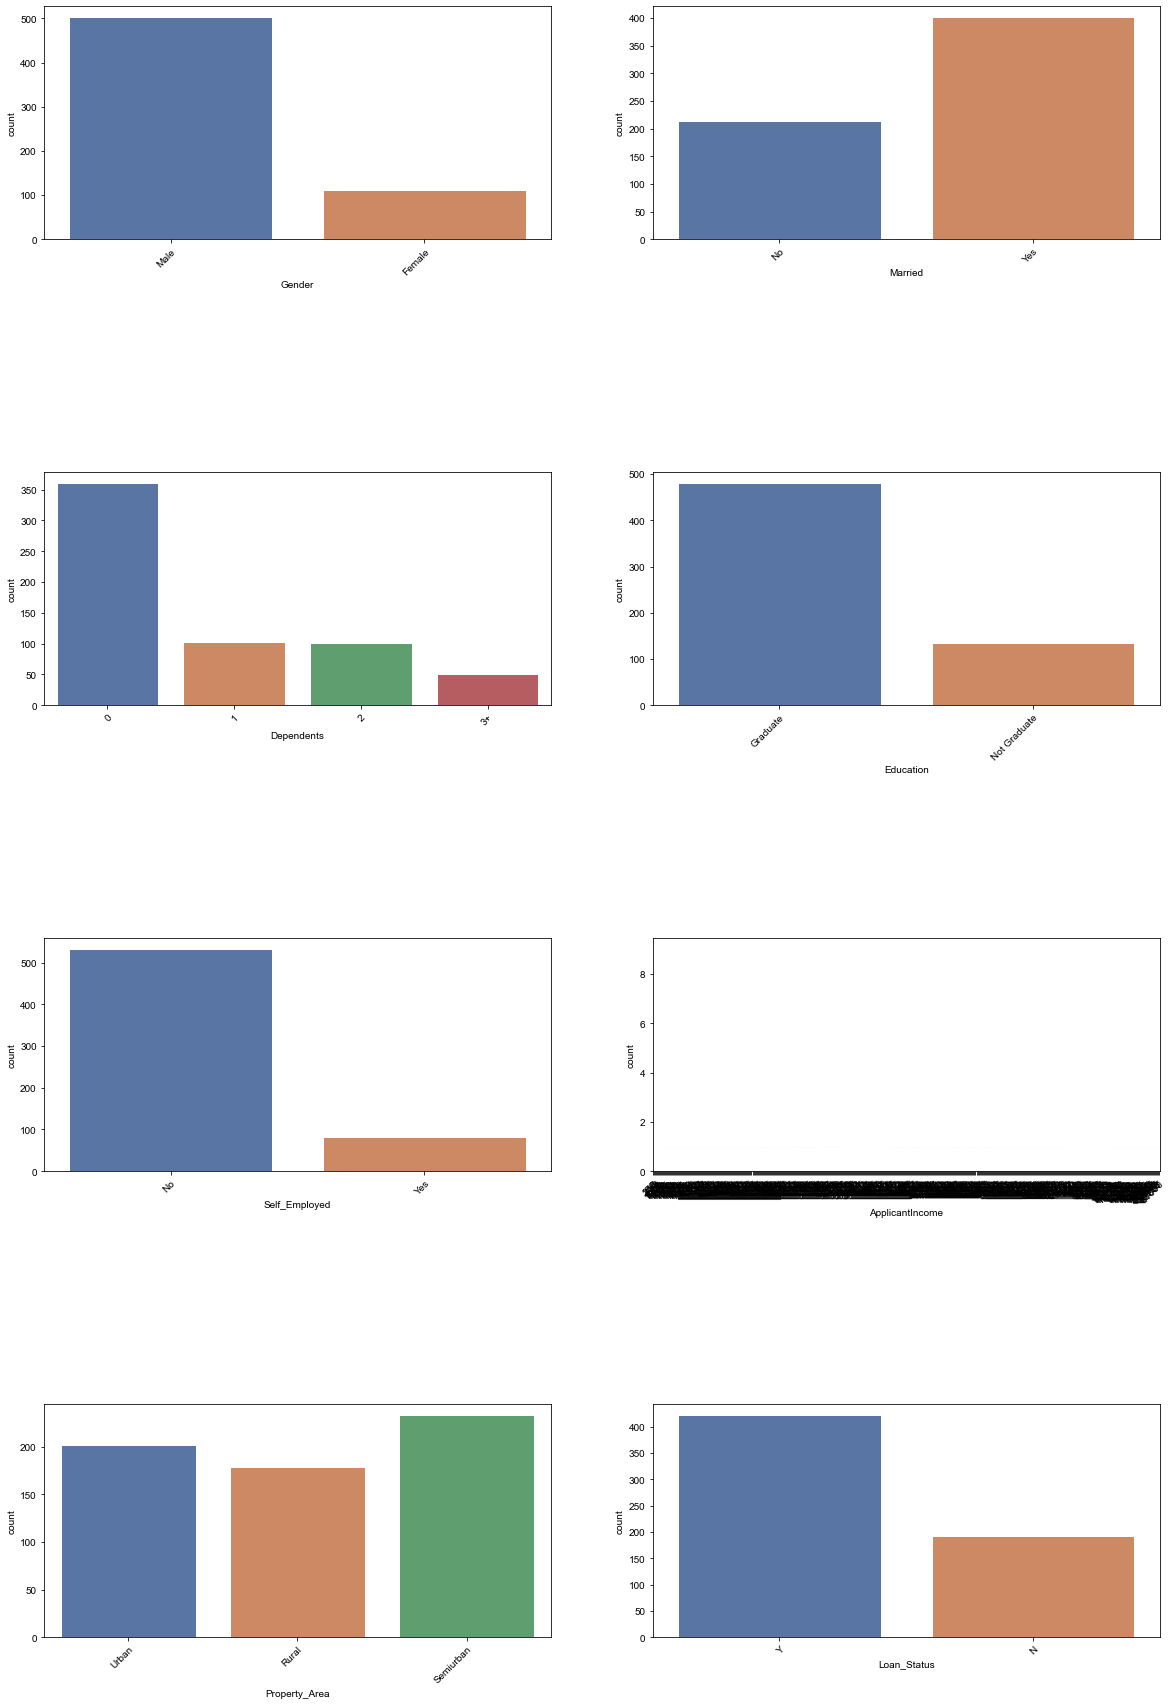

In [46]:
plot_categorical_columns(train)

** Let's plot numerical columns. Using standard and customized function.**

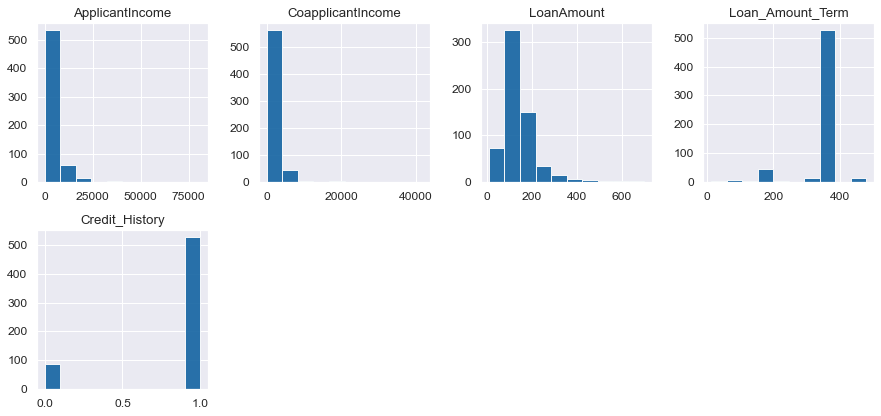

In [47]:
hist = train.hist(figsize = (15, 22), layout=(6, 4) , color='#1363a1',alpha=0.9 )

In [48]:
def plot_numerical_columns(df):
    df = df[df.select_dtypes([np.int64,np.float64]).columns]
    lcols = 2
    lrows = math.ceil(len(df.columns)/lcols)
    plt.figure(figsize=(20,10))
    plt.subplots_adjust(wspace=0.2, hspace=0.5) 
    for i, column in enumerate(df.columns):
        plt.subplot(lrows,lcols,i+1)
        sns.distplot(df[column])

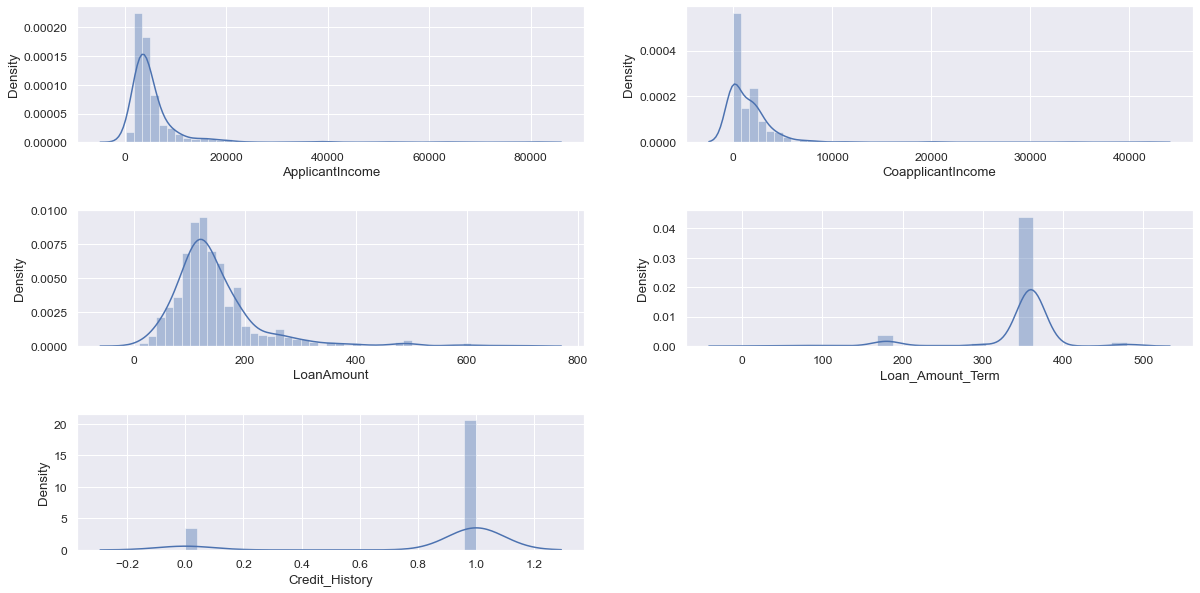

In [49]:
plot_numerical_columns(train)
### Not sure why I get this error

In [50]:
train.select_dtypes(include=object)

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,Urban,Y
1,Male,Yes,1,Graduate,No,Rural,N
2,Male,Yes,0,Graduate,Yes,Urban,Y
3,Male,Yes,0,Not Graduate,No,Urban,Y
4,Male,No,0,Graduate,No,Urban,Y
...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,Rural,Y
610,Male,Yes,3+,Graduate,No,Rural,Y
611,Male,Yes,1,Graduate,No,Urban,Y
612,Male,Yes,2,Graduate,No,Urban,Y


In [51]:
train.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

<div class="alert alert-block alert-warning">
<b>3.2 Bi-variate Analysis</b>
</div> </a><a class="anchor" id="bivariate"></a>

**Let's use crosstab function.**


In [52]:
train

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,151.0,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [53]:
col = train.Credit_History
pd.crosstab(train[l_target], [col], margins=True, margins_name="Total", normalize='index')

Credit_History,0.0,1.0
Loan_Status,,
N,0.427083,0.572917
Y,0.016588,0.983412
Total,0.144951,0.855049


In [54]:
col = train.Credit_History
pd.crosstab(train[l_target], [col], margins=True, margins_name="Total")
# These values are using absolute numbers

Credit_History,0.0,1.0,Total
Loan_Status,,,
N,82,110,192
Y,7,415,422
Total,89,525,614


** pairplot() takes a broader view, showing all pairwise relationships and the marginal distributions, optionally conditioned on a categorical variable :**

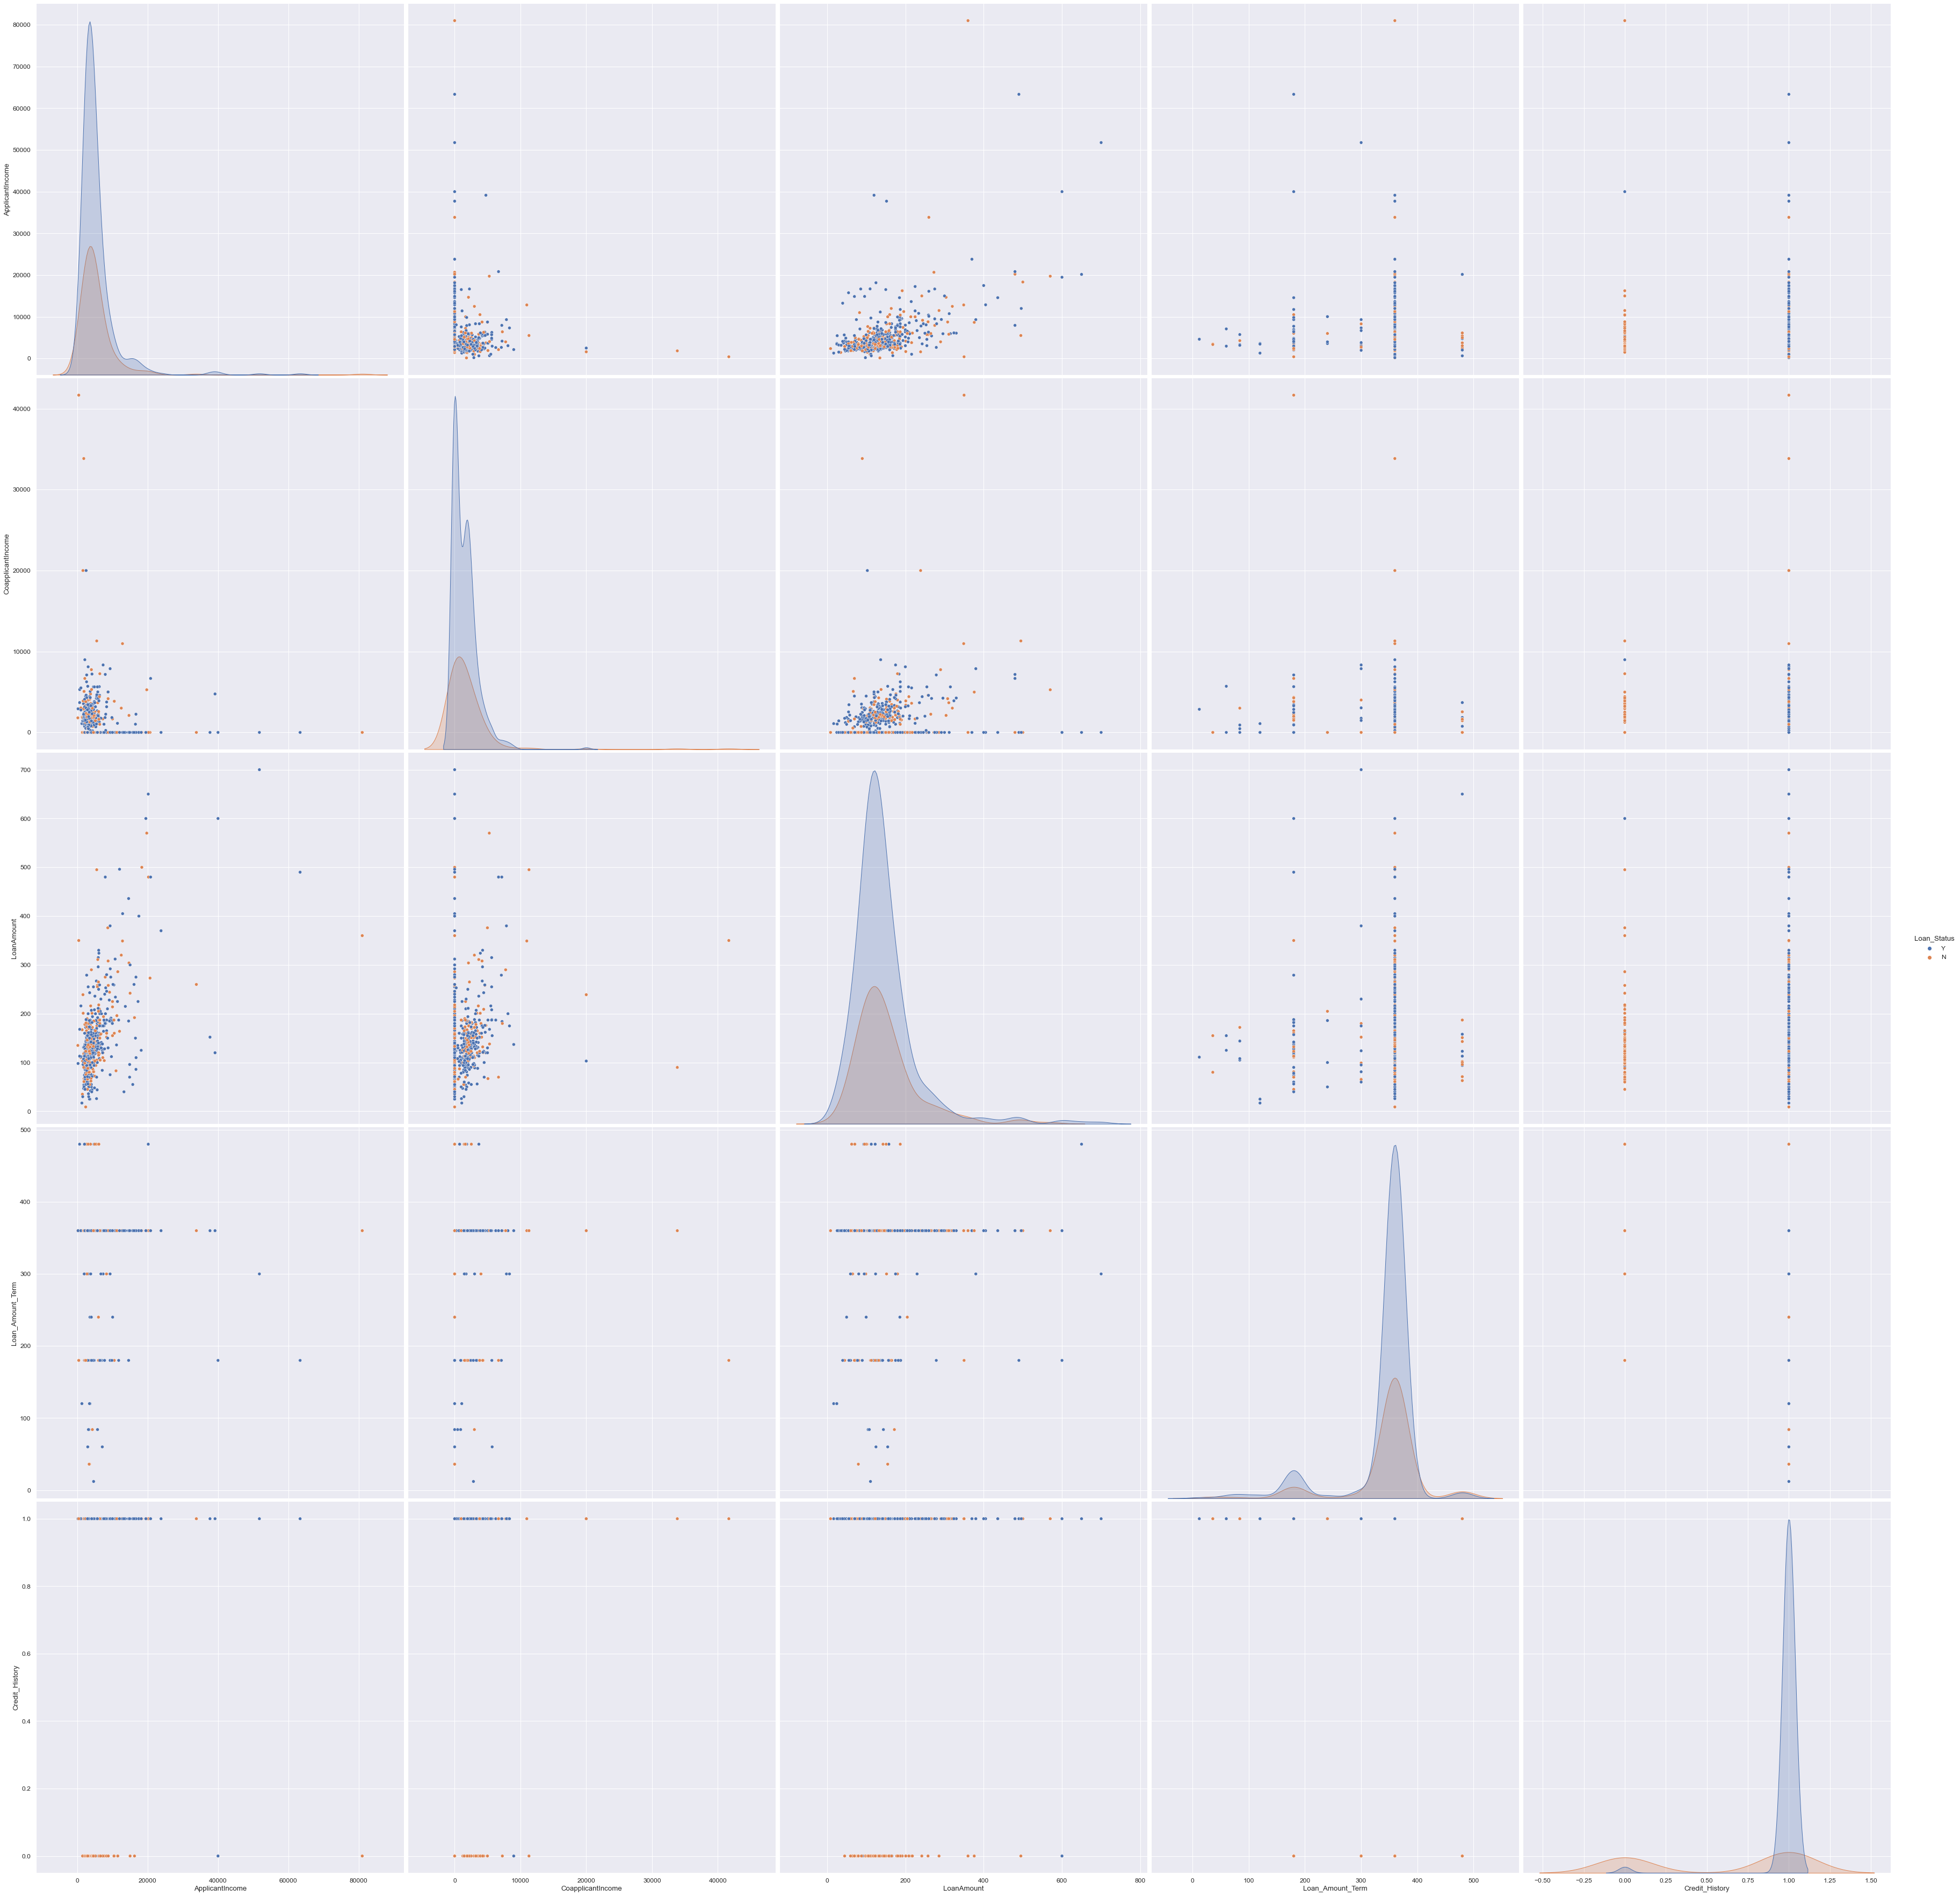

In [55]:
sns.pairplot(data=train, hue=l_target,  height=10);

In [56]:
train

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,151.0,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


<div class="alert alert-block alert-info">
<b><h1>4. Feature Engineering</h1></div>
</a><a class="anchor" id="engineering"></a>

<strong>Let's move original tables to new ones.</strong>

In [104]:
train1 = train.copy()

In [105]:
print("Column data types and their frequency\n{}".format(train1.dtypes.value_counts()))

Column data types and their frequency
object     7
float64    4
int64      1
dtype: int64


In [106]:
list_column_values(train1,15,'True')

**Results:**

Gender                    ==> ['Female', 'Male']
Married                   ==> ['No', 'Yes']
Dependents                ==> ['0', '1', '2', '3+']
Education                 ==> ['Graduate', 'Not Graduate']
Self_Employed             ==> ['No', 'Yes']
ApplicantIncome           ==> more than 15 values
CoapplicantIncome         ==> more than 15 values
LoanAmount                ==> more than 15 values
Loan_Amount_Term          ==> [12.0, 36.0, 60.0, 84.0, 120.0, 180.0, 240.0, 300.0, 360.0, 480.0]
Credit_History            ==> [0.0, 1.0]
Property_Area             ==> ['Rural', 'Semiurban', 'Urban']
Loan_Status               ==> ['N', 'Y']


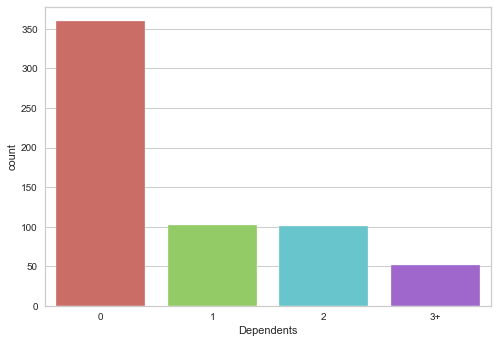

In [107]:
sns.countplot(x='Dependents',data=train1, palette='hls')
plt.show();

<div class="alert alert-block alert-warning">
<b>4.1 General Transformation</b>
</div> </a><a class="anchor" id="general_trans"></a>

<strong>Let's replace categorical values with numerical values.</strong>

In [108]:
#train['education_level'].replace(['Primary School','High School','Graduate','Masters','Phd'],[1,2,3,4,5],inplace=True)

train1['Dependents'].replace(['0', '1', '2', '3+'],[0,1,2,3],inplace=True)


In [109]:
list_column_values(train1,15,'True')

**Results:**

Gender                    ==> ['Female', 'Male']
Married                   ==> ['No', 'Yes']
Dependents                ==> [0, 1, 2, 3]
Education                 ==> ['Graduate', 'Not Graduate']
Self_Employed             ==> ['No', 'Yes']
ApplicantIncome           ==> more than 15 values
CoapplicantIncome         ==> more than 15 values
LoanAmount                ==> more than 15 values
Loan_Amount_Term          ==> [12.0, 36.0, 60.0, 84.0, 120.0, 180.0, 240.0, 300.0, 360.0, 480.0]
Credit_History            ==> [0.0, 1.0]
Property_Area             ==> ['Rural', 'Semiurban', 'Urban']
Loan_Status               ==> ['N', 'Y']


In [110]:

train1['Education'].replace(['Graduate', 'Not Graduate'],[1,2],inplace=True)


In [111]:
train1['Gender'].replace(['Female', 'Male', 'nan'],[1,2,np.nan],inplace=True)

In [112]:
train1['Self_Employed'].replace(['No', 'Yes'],[0,1],inplace=True)

In [113]:
train1['Property_Area'].replace(['Rural', 'Semiurban', 'Urban'],[1, 2, 3],inplace=True)

In [114]:

train1['Married'].replace(['No', 'Yes'],[1,0],inplace=True)

In [115]:
list_column_values(train1,15,'True')

**Results:**

Gender                    ==> [1, 2]
Married                   ==> [0, 1]
Dependents                ==> [0, 1, 2, 3]
Education                 ==> [1, 2]
Self_Employed             ==> [0, 1]
ApplicantIncome           ==> more than 15 values
CoapplicantIncome         ==> more than 15 values
LoanAmount                ==> more than 15 values
Loan_Amount_Term          ==> [12.0, 36.0, 60.0, 84.0, 120.0, 180.0, 240.0, 300.0, 360.0, 480.0]
Credit_History            ==> [0.0, 1.0]
Property_Area             ==> [1, 2, 3]
Loan_Status               ==> ['N', 'Y']


<strong>Let's convert remaining object columns to strings.</strong>

In [116]:
def object_to_str(df, to_str_cols):
    for col in to_str_cols:
        df[col] = df[col].astype(str)
    return df

** I don't have any columns with values left as string. So leaving it as is **

<div class="alert alert-block alert-warning">
<b>4.2 Encoding</b>
</div> </a><a class="anchor" id="encoding"></a>

In [117]:
train1.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,2,1,0,1,0,5849,0.0,151.0,360.0,1.0,3,Y
1,2,0,1,1,0,4583,1508.0,128.0,360.0,1.0,1,N
2,2,0,0,1,1,3000,0.0,66.0,360.0,1.0,3,Y
3,2,0,0,2,0,2583,2358.0,120.0,360.0,1.0,3,Y
4,2,1,0,1,0,6000,0.0,141.0,360.0,1.0,3,Y


In [118]:
print("Column data types and their frequency\n{}".format(train1.dtypes.value_counts()))

Column data types and their frequency
int64      7
float64    4
object     1
dtype: int64


<strong>LABEL ENCODER</strong>

<strong> It Doesn't looks like that I need to use any of the encoding methods</strong>

# SCALING

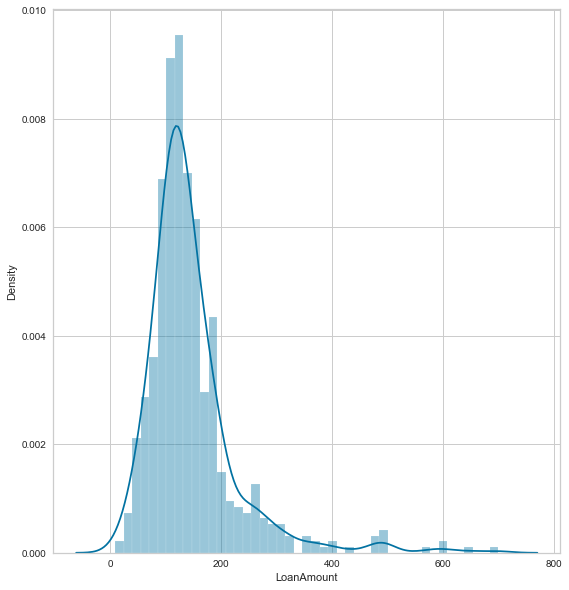

In [119]:
plot_numerical_columns(pd.DataFrame(train1['LoanAmount']))

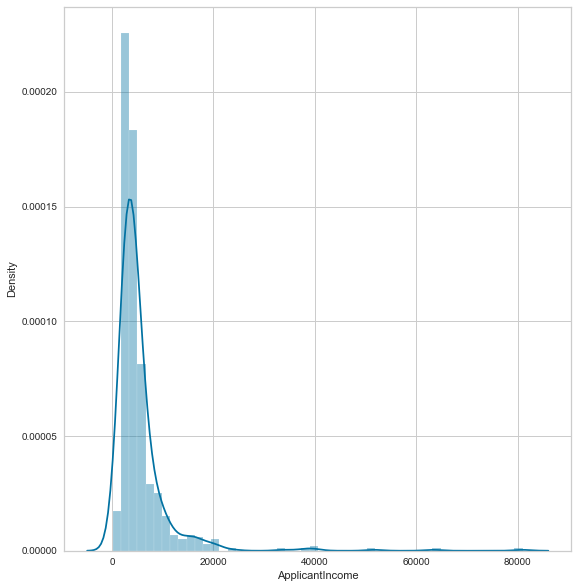

In [120]:
plot_numerical_columns(pd.DataFrame(train1['ApplicantIncome']))

In [121]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train1['LoanAmount'] = pd.DataFrame(scaler.fit_transform(train1[['LoanAmount']]))
train1['ApplicantIncome'] = pd.DataFrame(scaler.fit_transform(train1[['ApplicantIncome']]))


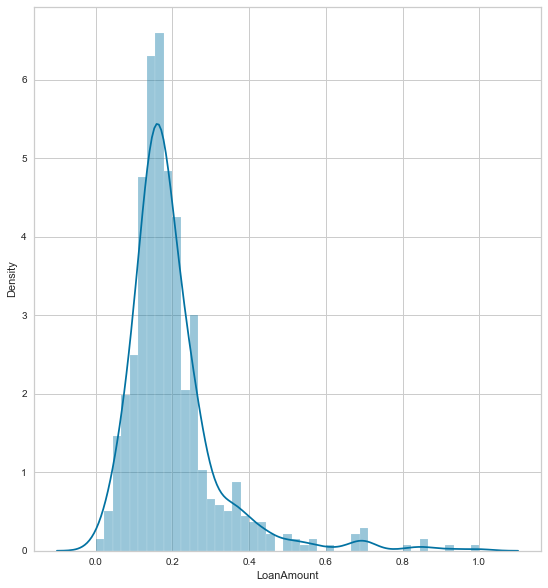

In [122]:
plot_numerical_columns(pd.DataFrame(train1['LoanAmount']))

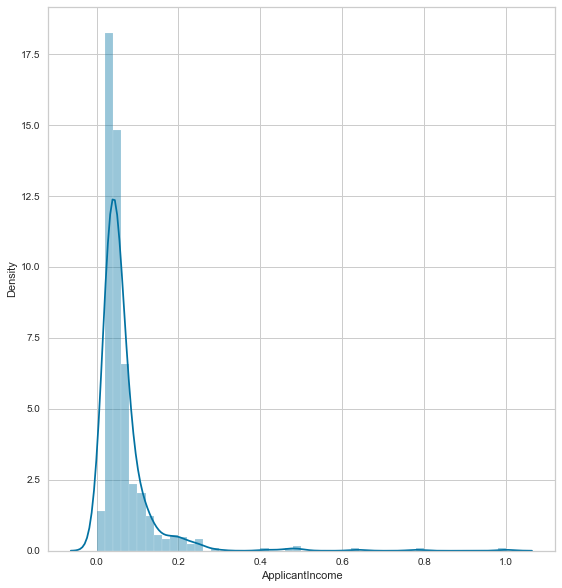

In [123]:
plot_numerical_columns(pd.DataFrame(train1['ApplicantIncome']))

<div class="alert alert-block alert-info">
<b><h1>5. Model Training</h1></div>
<a class="anchor" id="training"></a>

In [169]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import adjusted_mutual_info_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import sys
from sklearn.metrics import accuracy_score, homogeneity_score,adjusted_rand_score
from sklearn.metrics import silhouette_score,completeness_score,v_measure_score

from sklearn.mixture import GaussianMixture
from scipy.stats import kurtosis
from scipy.spatial.distance import cdist

import itertools
import timeit
from time import time


<strong>Let's split the training dataset</strong>

In [125]:
train1['Loan_Status'] = train1['Loan_Status'].map({'Y': 1, 'N': 0})

In [126]:
y = train1[l_target].reset_index(drop=True)
X = train1.drop([l_target], axis=1)

In [127]:
X.shape, y.shape

((614, 11), (614,))

<div class="alert alert-block alert-warning">
<b>1.1  K-means</b>
</div> </a><a class="anchor" id="encoding"></a>

In [128]:
def plotSilhouette(dataX, datay, clusters):
    silhouette = {}
    homogenity = {}
    for cluster in clusters:
        kmeans = KMeans(n_clusters=cluster,init='k-means++', max_iter=1000, random_state=100).fit(X)
        label = kmeans.labels_
        silhouette_coeff = silhouette_score(dataX, label, metric='euclidean')
        homogenity_score = homogeneity_score(datay, label)
        silhouette[cluster] = silhouette_coeff
        homogenity[cluster] = homogenity_score
    plt.figure()
    plt.plot(list(silhouette.keys()), list(silhouette.values()), label="Silhouette")
    plt.plot(list(homogenity.keys()), list(homogenity.values()), label="Homogeneity")
    plt.legend()
    plt.title("Silhouette & Homogenity")
    plt.ylabel("Silhouette coefficient")
    plt.xlabel("Number of clusters")
    plt.show()
    




def plotSilhouetteEM(dataX, datay, clusters):
    silhouetteEM = {}
    homogenityEM = {}
    gaussianScore = {}
    for cluster in clusters:
        gmm = GaussianMixture(n_components=cluster, max_iter=1000, random_state=100, n_init=5).fit(dataX)
        label = gmm.predict(dataX)
        silhouette_coeff = silhouette_score(dataX, label)
        homogenity_score = homogeneity_score(datay, label)
        silhouetteEM[cluster] = silhouette_coeff
        homogenityEM[cluster] = homogenity_score
        gaussianScore[cluster] = gmm.score(dataX)
    plt.figure()
    plt.plot(list(silhouetteEM.keys()), list(silhouetteEM.values()), label="Silhouette")
    plt.plot(list(homogenityEM.keys()), list(homogenityEM.values()), label="Homogeneity")
    plt.legend()
    plt.title("Expectation Maximization")
    plt.ylabel("Silhouette Coefficient")
    plt.xlabel("Number of clusters")
    plt.show()

    

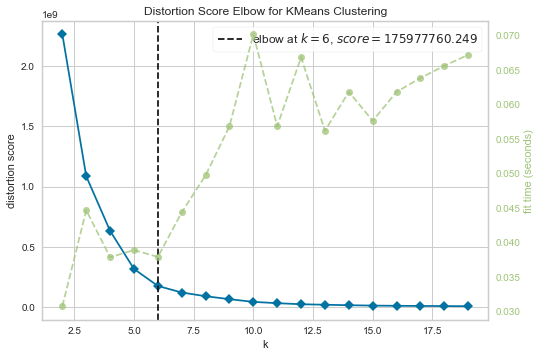

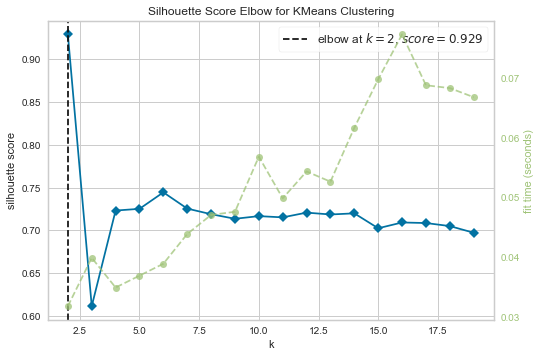

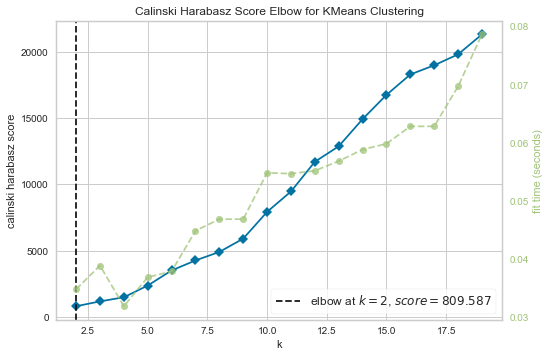

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [180]:
from sklearn import datasets
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from sklearn import datasets
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
#
#
# Instantiate the clustering model and visualizer
#
km = KMeans(random_state=100)
visualizer = KElbowVisualizer(km, k=(2,20) )
 
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


#
#
# Instantiate the clustering model and visualizer
#
km = KMeans(random_state=100)
visualizer = KElbowVisualizer(km, k=(2,20), metric='silhouette' )
 
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# Calinski Harabasz Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state=100)
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20),metric='calinski_harabasz', timings= True)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

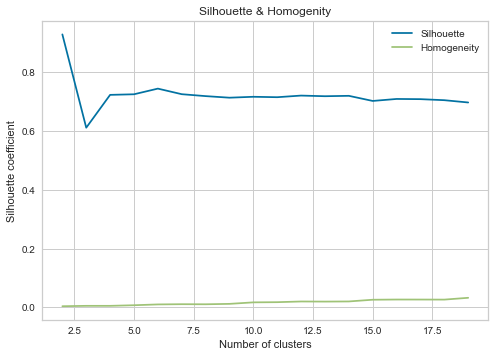

In [183]:
##Silhouette & homogenity Plotting

clusters = list(range(2, 20, 1))
plotSilhouette(X, y, clusters)

<div class="alert alert-block alert-warning">
<b>1.2 Expectation Maximization</b>
</div> </a><a class="anchor" id="encoding"></a>

In [133]:
# expectation maximization plot showing bic and silhouette score



def em_plot(dataName, data):
    aic = []
    bic = []
    scores = []
    for i in range(2,15):
        gmm = GaussianMixture(n_components=i, random_state=100, covariance_type='full')
        gmm.fit(data)
        aic.append(gmm.aic(data))
        bic.append(gmm.bic(data))
        
        gmm_labels = gmm.predict(data)
        scores.append(silhouette_score(data, gmm_labels))
                
    # Plot the data
    title = "Expectation Maximization of " + dataName
    plt.figure(figsize=(6, 10))
    plt.suptitle(title, y=1.05, fontsize=16)
    
    plt.subplot(311)
    plt.plot(range(2,15), aic, 'x-')
    plt.title("AIC Score vs. Number of Clusters")
    plt.xlabel('Number of clusters')
    plt.ylabel('AIC')
    plt.grid()
    
    plt.subplot(312)
    plt.plot(range(2,15), bic, 'x-')
    plt.title("BIC Score vs. Number of Clusters")
    plt.xlabel('Number of clusters')
    plt.ylabel('BIC')
    plt.grid()
    
    plt.subplot(313)
    plt.plot(range(2,15),scores, 'x-')
    plt.title("Silhouette Score vs. Number of Clusters")
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.tight_layout()
    plt.grid()
    plt.show()

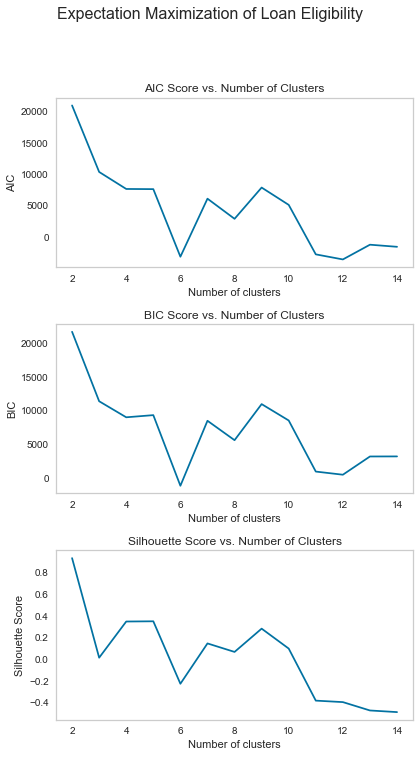

In [136]:
em_plot('Loan Eligibility', X)

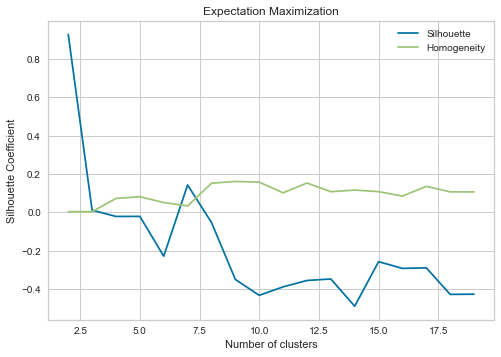

In [137]:
clusters = list(range(2, 20, 1))
plotSilhouetteEM(X, y, clusters)

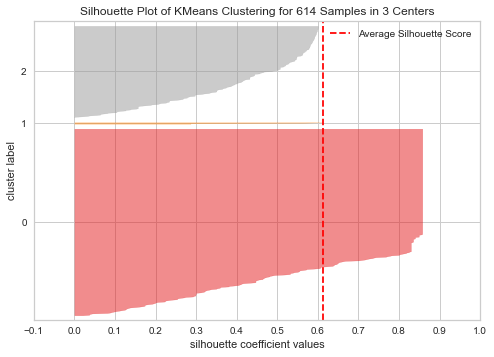

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 614 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [139]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Instantiate the clustering model and visualizer 
model = KMeans(3)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

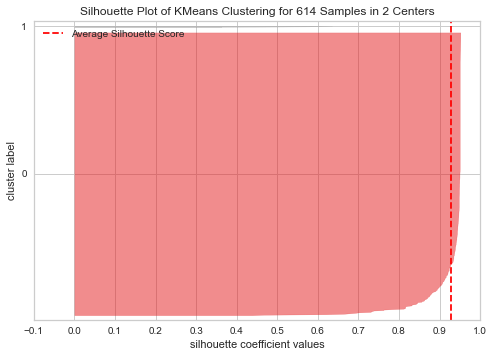

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 614 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [140]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Instantiate the clustering model and visualizer 
model = KMeans(2)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

In [176]:
def relabel(cl):
    """Relabel a clustering with three clusters
    to match the original classes."""
    if np.max(cl) != 1:
        return cl
    perms = np.array(list(permutations((0, 1))))
    i = np.argmin([np.sum(np.abs(perm[cl] - y))
                   for perm in perms])
    p = perms[i]
    return p[cl]
def display_clustering(labels, title):
    """Plot the data points with the cluster
    colors."""

    # We relabel the classes when there are 3 clusters
    labels = relabel(labels)
    fig, axes = plt.subplots(1, 2, figsize=(8, 3),
                             sharey=True)
    # Display the points with the true labels on the
    # left, and with the clustering labels on the
    # right.
    for ax, c, title in zip(
            axes,
            [y, labels],
            ["True labels", title]):
        #ax.scatter(X[:, 0], X[:, 1], c=c, s=30,
        ax.scatter(X['ApplicantIncome'], X['LoanAmount'], c=c, s=30,           
                   linewidths=0, cmap=plt.cm.rainbow)
        ax.set_title(title)

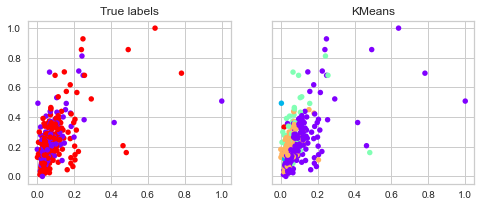

In [177]:
km = KMeans(5)
km.fit(X)

labels = relabel(km.labels_)
labels
display_clustering(km.labels_, "KMeans")

<div class="alert alert-block alert-warning">
<b>2 Dimensionality Reduction</b>
</div> </a><a class="anchor" id="encoding"></a>

In [151]:
# Dimensionality reduction imports
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection as RP
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.linalg import pinv
from scipy.stats import kurtosis
from scipy import sparse 


def print_line(title=None):
    print(80*'-')
    if title:
        print('* ', title, ' *')
        print(80*'-')

# borrowed from https://github.com/JonathanTay/CS-7641-assignment-3/
def reconstruction_error(algo, data):
    W = algo.components_
    if sparse.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p @ W) @ (data.T)).T
    errors = np.square(data - reconstructed)
    return np.nanmean(errors)

#
# PCA
#

def calc_pca_components(data, dataName):
    t0 = time()
    
    pca = PCA(n_components=data.shape[1], random_state=0)
    pca.fit(data)
    var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
    
    end = time() - t0
    
    plt.title('PCA Analysis for %s' % dataName)
    plt.ylabel('Cumulative % Variance')
    plt.xlabel('Number of Features')
    plt.axhline(y=95, color='gray', linestyle='--', label='95% Variance')
    plt.plot(range(1,data.shape[1]+1), var)
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
    
    numComponents = np.argmax(var>95) + 1
    
    
    print('%s total features: %d' %(dataName, data.shape[1]))
    print('Best Number of PCA Components: %d' % numComponents)
    print('Total Time: %.3f seconds' % end)

#
# ICA
#
def calc_ica_components(data, dataName):
    t0 = time()
    
    dimensions = data.shape[1]+1
    kurtosis = []
    for dim in range(2,dimensions):
        ica = FastICA(n_components=dim, max_iter=600, random_state=0)
        res = ica.fit_transform(data)
        tmp = pd.DataFrame(res)
        k   = tmp.kurt(axis=0)
        kurtosis.append(k.abs().mean())
        
    end = time() - t0
    
    optimalComponents = np.argmax(kurtosis)
    
    plt.title('ICA Analysis for %s' % dataName)
    plt.ylabel('Kurtosis')
    plt.xlabel('Number of Features')
    plt.plot(range(2,dimensions), kurtosis)
    plt.grid()
    plt.show()
    
    print('Total Number of Features:', data.shape[1])
    print('Best Number of ICA Components:', optimalComponents+2)
    print('Total Time: %.3f seconds' % end)
    
    return optimalComponents
    
#
# RP
#
def calc_rp_components(data, dataName, tries=100):
    t0 = time()
    
    dimensions = data.shape[1]+1
    kurtosis = []
    stddev_kurtosis = []
    lowerbound = []
    upperbound = []
    for dim in range(2,dimensions):
        kurts = []
        for t in range(tries):
            rp = RP(n_components=dim)
            res = rp.fit_transform(data)
            tmp = pd.DataFrame(res)
            k   = tmp.kurt(axis=0)
            kurts.append(k.abs().mean())
        kurtosis.append(np.mean(kurts))
        lowerbound.append(np.mean(kurts)-np.std(kurts))
        upperbound.append(np.mean(kurts)+np.std(kurts))
        
    optimalComponents = np.argmax(kurtosis)
    
    end = time() - t0
    
    plt.title('RP Analysis for %s: %d Iterations' % (dataName, tries))
    plt.ylabel('Kurtosis')
    plt.xlabel('Number of Features')
    plt.plot(range(2,dimensions), kurtosis)
    plt.fill_between(range(2, dimensions), lowerbound, upperbound, facecolor='gray', alpha=0.1)
    plt.grid()
    plt.show()
    
    print('Total Number of Features:', data.shape[1])
    print('Best Number of RP Components:', optimalComponents+2)
    print('Total Time: %.3f seconds' % end)
    
    return optimalComponents
    
#
# UFS
#
# function based on https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py
def calc_kbest(dataX, datay, dataName):
    t0 = time()
    
    kBest = SelectKBest(f_classif, k=4)
    kBest.fit(dataX, datay)
    scores = kBest.pvalues_
    scores[np.isnan(scores)]=0 # get rid of NaN's
    scores += 1e-308           # get rid of zero values
    scores = -np.log10(scores)
    scores /= scores.max()
    
    plt.title('UFS Analysis for %s' % dataName)
    plt.ylabel('Normalized Univariate Score')
    plt.xlabel('Feature Number')
    plt.bar(np.arange(dataX.shape[-1]),scores)
    plt.grid(alpha=0.3)
    plt.show()

    end = time() - t0
    print('Total Time: %.3f seconds' % end)

In [152]:
from sklearn.preprocessing import scale, LabelEncoder
X_scaled = scale(X)

--------------------------------------------------------------------------------
*  Loan Eligibility PCA  *
--------------------------------------------------------------------------------


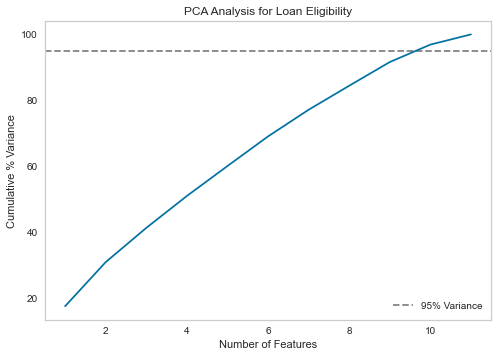

Loan Eligibility total features: 11
Best Number of PCA Components: 10
Total Time: 0.015 seconds
PCA Reconstruction Error:  7.736832729614101e-31
--------------------------------------------------------------------------------
*  Loan Eligibility ICA  *
--------------------------------------------------------------------------------


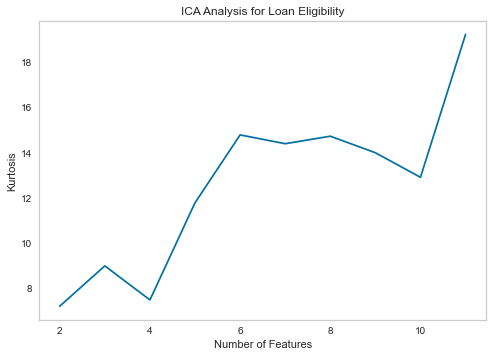

Total Number of Features: 11
Best Number of ICA Components: 11
Total Time: 0.054 seconds
ICA Reconstruction Error:  0.08349805919202823
--------------------------------------------------------------------------------
*  Loan Eligibility RP  *
--------------------------------------------------------------------------------


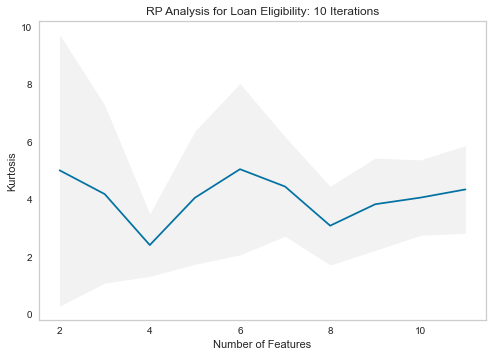

Total Number of Features: 11
Best Number of RP Components: 6
Total Time: 0.095 seconds
RP Reconstruction Error:  0.5890346888362005
--------------------------------------------------------------------------------
*  Loan Eligibility UFS  *
--------------------------------------------------------------------------------


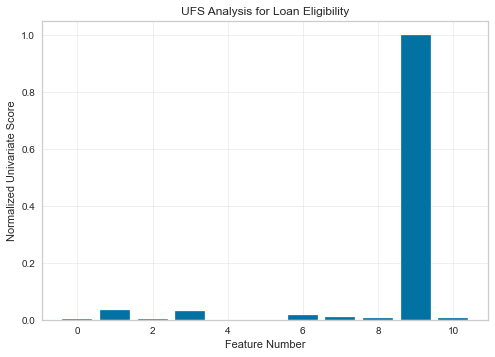

Total Time: 0.135 seconds


In [156]:
X_scaled = scale(X)

#
# PCA
#
            
print_line('Loan Eligibility PCA')
HR_pca_components = calc_pca_components(X_scaled, 'Loan Eligibility')
HR_PCA = PCA(n_components=HR_pca_components, random_state=100).fit(X_scaled)
HR_pca_sse = reconstruction_error(HR_PCA, X_scaled)
print('PCA Reconstruction Error: ', HR_pca_sse)



#
# ICA
#
print_line('Loan Eligibility ICA')
HR_ica_components = calc_ica_components(X_scaled, 'Loan Eligibility')
HR_ICA = FastICA(n_components=HR_ica_components, random_state=100).fit(X_scaled)
HR_ica_sse = reconstruction_error(HR_ICA, X_scaled)
print('ICA Reconstruction Error: ', HR_ica_sse)


#
# RP
#
print_line('Loan Eligibility RP')
HR_rp_components = calc_rp_components(X_scaled, 'Loan Eligibility', 10)
HR_RP = RP(n_components=HR_rp_components, random_state=100).fit(X_scaled)
HR_rp_sse = reconstruction_error(HR_RP, X_scaled)
print('RP Reconstruction Error: ', HR_rp_sse)


#
# UFS
#
print_line('Loan Eligibility UFS')
calc_kbest(X_scaled, y, 'Loan Eligibility')

In [184]:
from tabulate import tabulate

PCA_all_data = [["","PCA","ICA","RP","UFS"]]

PCA_all_data.append(["Number of Components",10,11,6,4 ])
PCA_all_data.append(["Process Time (seconds)",0.015 ,0.054, 0.095 ,  0.135])
PCA_all_data.append(["Reconstruction Error ",7.7e-31,0.083,0.589,'N/A'])


In [185]:
print(tabulate(PCA_all_data,headers='firstrow',tablefmt='fancy_grid'))

╒════════════════════════╤══════════╤════════╤═══════╤═══════╕
│                        │      PCA │    ICA │    RP │ UFS   │
╞════════════════════════╪══════════╪════════╪═══════╪═══════╡
│ Number of Components   │ 10       │ 11     │ 6     │ 4     │
├────────────────────────┼──────────┼────────┼───────┼───────┤
│ Process Time (seconds) │  0.015   │  0.054 │ 0.095 │ 0.135 │
├────────────────────────┼──────────┼────────┼───────┼───────┤
│ Reconstruction Error   │  7.7e-31 │  0.083 │ 0.589 │ N/A   │
╘════════════════════════╧══════════╧════════╧═══════╧═══════╛


<div class="alert alert-block alert-warning">
<b>3 Clustering + Dimensionality Reduction</b>
</div> </a><a class="anchor" id="encoding"></a>

In [187]:
# Run all kmeans and plot results
def compare_kmeans(dataName, datasets):
    # Loop through all datasets
    all_sse = []
    all_scores = []
    all_methods = []
    for d in datasets:
        data   = d[1]
        sse    = []
        scores = []
        
        # try different cluster sizes
        for i in range(2,15):
            kmeans = KMeans(n_clusters=i,init='k-means++', random_state=100)
            kmeans.fit(data)
            sse.append(kmeans.inertia_)
            
            kmeans_labels = kmeans.predict(data)
            scores.append(silhouette_score(data, kmeans_labels))
            
        all_sse.append(sse)
        all_scores.append(scores)
        all_methods.append(d[0])
                    
    # Plot the data
    title = "K-means of " + dataName + " Using Dimensionality Reduction"
    plt.figure(figsize=(10, 8))
    plt.suptitle(title, y=1.05, fontsize=16)
    
    # create method to change line types
    lines = ["o-", "x-", "x--", "x-.", "x:"]
    
    plt.subplot(211)
    for i,sse in enumerate(all_sse):
        plt.plot(range(2,15), sse, lines[i], label=all_methods[i])
    plt.title("Sum of Squares vs. Number of Clusters")
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum Square Error')
    plt.legend()
    plt.grid()
    
    plt.subplot(212)
    for i, score in enumerate(all_scores):
        plt.plot(range(2,15), score, lines[i], label=all_methods[i])
    plt.title("Silhouette Score vs. Number of Clusters")
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()
    
def compare_em(dataName, datasets):
    # Loop through all datasets
    all_aic     = []
    all_bic     = []
    all_scores  = []
    all_dims    = []
    all_methods = []
    for d in datasets:
        data   = d[1]
        dimensions = data.shape[1] + 1
        all_dims.append(list(range(2,dimensions)))
        
        aic    = []
        bic    = []
        scores = []
        
        for i in range(2,dimensions):
            gmm = GaussianMixture(n_components=i, random_state=0)
            gmm.fit(data)
            aic.append(gmm.aic(data))
            bic.append(gmm.bic(data))
        
            gmm_labels = gmm.predict(data)
            scores.append(silhouette_score(data, gmm_labels))
        
        all_aic.append(aic)
        all_bic.append(bic)
        all_scores.append(scores)
        all_methods.append(d[0])
    
    # Plot the data
    title = "EM of " + dataName + " Using Dimensionality Reduction"
    fig = plt.figure(figsize=(10, 8))
    
    plt.suptitle(title, y=1.05, fontsize=16)
    
    # create method to change line types
    lines = ["o-", "x-", "x--", "x-.", "x:"]
    
    plt.subplot(311)
    for i,aic in enumerate(all_aic):
        plt.plot(all_dims[i], aic, lines[i], label=all_methods[i])
    plt.title("AIC vs. Number of Components")
    plt.xlabel('Number of Components')
    plt.ylabel('AIC')
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.subplot(312)
    for i,bic in enumerate(all_bic):
        plt.plot(all_dims[i], bic, lines[i], label=all_methods[i])
    plt.title("BIC Score vs. Number of Components")
    plt.xlabel('Number of Components')
    plt.ylabel('BIC')
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    
    plt.subplot(313)
    for i,score in enumerate(all_scores):
        plt.plot(all_dims[i], score, lines[i], label=all_methods[i])
    plt.title("Silhouette Score vs. Number of Components")
    plt.xlabel('Number of Components')
    plt.ylabel('Silhouette Score')
    plt.tight_layout()
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
# code based on example found at:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py
def bench_kmeans(estimator, labels, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             homogeneity_score(labels, estimator.labels_),
             completeness_score(labels, estimator.labels_),
             v_measure_score(labels, estimator.labels_),
             adjusted_rand_score(labels, estimator.labels_),
             adjusted_mutual_info_score(labels,  estimator.labels_),
             silhouette_score(data, estimator.labels_, metric='euclidean')))
   
def bench_em(estimator, labels, name, data):
    t0 = time()
    estimator.fit(data)
    gmm_labels = estimator.predict(data)
    print('%-9s\t%.2fs\t%i\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.aic(data), estimator.bic(data),
             homogeneity_score(labels, gmm_labels),
             completeness_score(labels, gmm_labels),
             v_measure_score(labels, gmm_labels),
             adjusted_rand_score(labels, gmm_labels),
             adjusted_mutual_info_score(labels,  gmm_labels),
             silhouette_score(data, gmm_labels, metric='euclidean')))

In [188]:
HR_PCA = PCA(n_components=10, random_state=0).fit_transform(X_scaled)
HR_ICA = FastICA(n_components=11, random_state=0).fit_transform(X_scaled)
HR_RP  = RP(n_components=6, random_state=0).fit_transform(X_scaled)
HR_UFS = SelectKBest(f_classif, k=4).fit_transform(X_scaled, y)

HR_data = []
HR_data.append(['Original', X_scaled])
HR_data.append(['PCA', HR_PCA])
HR_data.append(['ICA', HR_ICA])
HR_data.append(['RP',  HR_RP])
HR_data.append(['UFS', HR_UFS])

### K-means

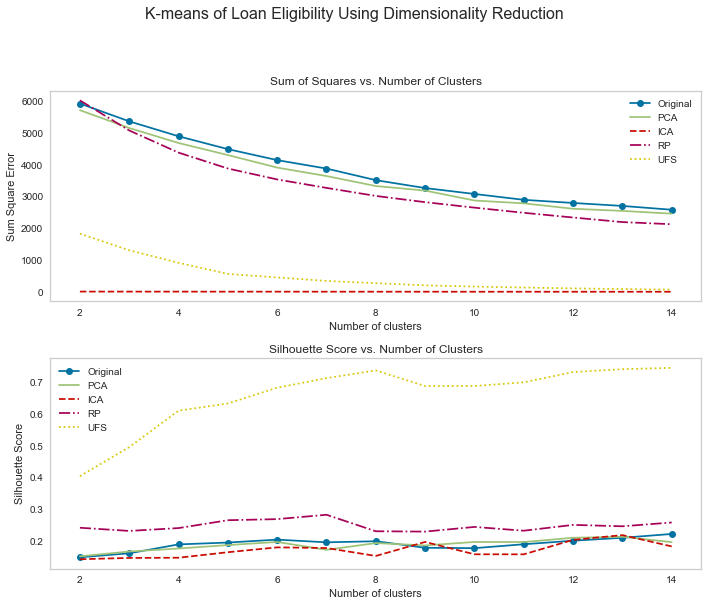

--------------------------------------------------------------------------------
*  K-Means Loan Eligibility Benchmark  *
--------------------------------------------------------------------------------
init		time	inertia	homog	compl	v-meas	ARI	AMI	silhouette
_____________________________________________________________________________________
Original 	0.04s	5933	0.005	0.004	0.004	0.017	0.003	0.148
PCA-based	0.04s	5724	0.005	0.004	0.004	0.017	0.003	0.152
ICA-based	0.03s	9	0.006	0.007	0.006	0.033	0.005	0.143
RP-based 	0.03s	6033	0.018	0.016	0.017	0.024	0.016	0.242
UFS-based	0.02s	1834	0.006	0.005	0.006	0.022	0.004	0.404


In [189]:
# Create k-means plots
compare_kmeans('Loan Eligibility', HR_data)

# Create k-means benchmark table
print_line('K-Means Loan Eligibility Benchmark')
print('init\t\ttime\tinertia\thomog\tcompl\tv-meas\tARI\tAMI\tsilhouette')
print(85*'_')
bench_kmeans(KMeans(init='k-means++', n_clusters=2), labels=y, name="Original",  data=X_scaled)
bench_kmeans(KMeans(init='k-means++', n_clusters=2), labels=y, name="PCA-based", data=HR_PCA)
bench_kmeans(KMeans(init='k-means++', n_clusters=2), labels=y, name="ICA-based", data=HR_ICA)
bench_kmeans(KMeans(init='k-means++', n_clusters=2), labels=y, name="RP-based",  data=HR_RP)
bench_kmeans(KMeans(init='k-means++', n_clusters=2), labels=y, name="UFS-based", data=HR_UFS)

### Expectation Maximization

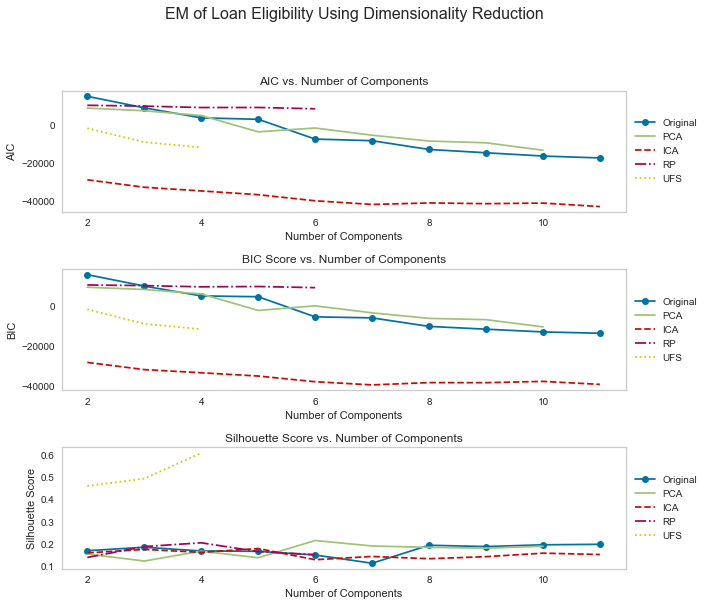

--------------------------------------------------------------------------------
*  EM Loan Eligibility Benchmark  *
--------------------------------------------------------------------------------
init		time	aic	bic	homog	compl	v-meas	ARI	AMI	silhouette
_____________________________________________________________________________________
Original 	0.03s	9116	10146	0.001	0.001	0.001	0.011	-0.001	0.186
PCA-based	0.02s	7579	8450	0.006	0.003	0.004	0.010	0.002	0.124
ICA-based	0.01s	-32593	-31563	0.229	0.174	0.198	0.233	0.196	0.176
RP-based 	0.02s	10016	10382	0.066	0.040	0.050	0.059	0.048	0.189
UFS-based	0.01s	-8907	-8713	0.231	0.169	0.195	0.235	0.193	0.495


In [190]:
# Create k-means plots
compare_em('Loan Eligibility', HR_data)

# Create k-means benchmark table
print_line('EM Loan Eligibility Benchmark')
print('init\t\ttime\taic\tbic\thomog\tcompl\tv-meas\tARI\tAMI\tsilhouette')
print(85*'_')
bench_em(GaussianMixture(n_components=3, random_state=0), labels=y, name="Original",  data=X_scaled)
bench_em(GaussianMixture(n_components=3, random_state=0), labels=y, name="PCA-based", data=HR_PCA)
bench_em(GaussianMixture(n_components=3, random_state=0), labels=y, name="ICA-based", data=HR_ICA)
bench_em(GaussianMixture(n_components=3, random_state=0), labels=y, name="RP-based",  data=HR_RP)
bench_em(GaussianMixture(n_components=3, random_state=0), labels=y, name="UFS-based", data=HR_UFS)

<div class="alert alert-block alert-warning">
<b>4 NN with Dimensionality Reduction</b>
</div> </a><a class="anchor" id="encoding"></a>

In [191]:
# Function based on:
# https://chrisalbon.com/machine_learning/model_evaluation/plot_the_learning_curve/
def plot_learning_curve(clf, X, y, title='Learning Curve'):
    train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
                                                        clf, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='f1',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 20),
                                                        return_times = True,
                                                        random_state = 0)

    # ------------------------------------------------------------------------------------------
    # Plot Learning Curve
    # ------------------------------------------------------------------------------------------
    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Draw lines
    plt.figure(1)
    plt.plot(train_sizes, train_mean, '--', label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', label="Cross-validation score")
    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

    # Create learning curve plot
    plt.title(title)
    plt.xlabel("Training Set Size"), plt.ylabel("F1 Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.grid()
    plt.show()
    
    # ------------------------------------------------------------------------------------------
    # Plot Scalability Curve
    # ------------------------------------------------------------------------------------------
    # Create mean and std of training times
    train_times_mean = np.mean(fit_times, axis=1)
    train_times_std  = np.std(fit_times, axis=1)
    
    # plot lines
    plt.figure(2)
    plt.plot(train_sizes, train_times_mean, 'o-')
    plt.fill_between(train_sizes, train_times_mean - train_times_std, train_times_mean + train_times_std, color='#DDDDDD')
    plt.title('Training Scalability')
    plt.xlabel('Training Set Size')
    plt.ylabel('Fit Times (s)')
    plt.grid()
    plt.show()
    
# Function based on:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion(clf, X_test, y_test, labels):
    
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(clf, X_test, y_test,
                                     display_labels=labels,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        #print(title)
        #print(disp.confusion_matrix)
        plt.show()

    plt.show()
    
    return 0

In [192]:
# split into train and test sets

HR_PCA = PCA(n_components=10, random_state=100).fit_transform(X_scaled)
HR_ICA = FastICA(n_components=11, random_state=100).fit_transform(X_scaled)
HR_RP  = RP(n_components=6, random_state=100).fit_transform(X_scaled)
HR_UFS = SelectKBest(f_classif, k=4).fit_transform(X_scaled, y)

HR_data = []
HR_data.append(['Original', X_scaled])
HR_data.append(['PCA', HR_PCA])
HR_data.append(['ICA', HR_ICA])
HR_data.append(['RP',  HR_RP])
HR_data.append(['UFS', HR_UFS])

### Neural Net Training

In [193]:
labels = ['Stay', 'Left']

--------------------------------------------------------------------------------
*  Original  *
--------------------------------------------------------------------------------
Neural Net model fit in 25.922 s
Best Score: 0.895 using {'hidden_layer_sizes': (40, 20), 'learning_rate': 'constant', 'solver': 'sgd'}


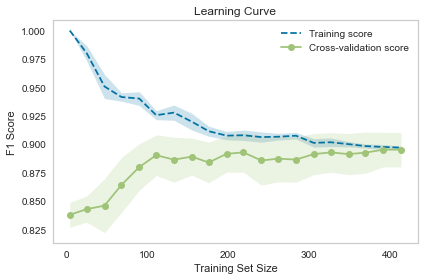

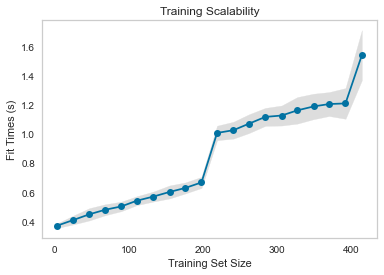

              precision    recall  f1-score   support

           0       0.89      0.40      0.55        60
           1       0.72      0.97      0.82        94

    accuracy                           0.75       154
   macro avg       0.80      0.68      0.69       154
weighted avg       0.78      0.75      0.72       154



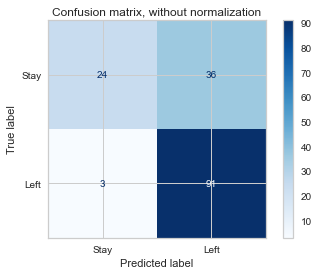

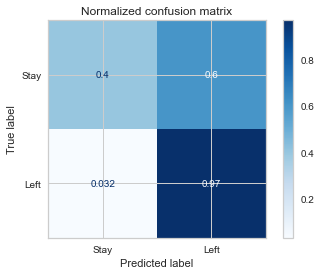

--------------------------------------------------------------------------------
*  PCA  *
--------------------------------------------------------------------------------
Neural Net model fit in 29.119 s
Best Score: 0.894 using {'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'solver': 'sgd'}


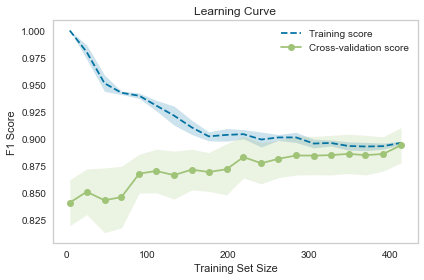

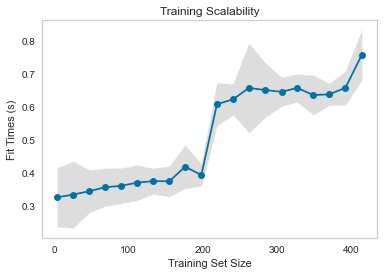

              precision    recall  f1-score   support

           0       0.81      0.42      0.55        60
           1       0.72      0.94      0.81        94

    accuracy                           0.73       154
   macro avg       0.76      0.68      0.68       154
weighted avg       0.75      0.73      0.71       154



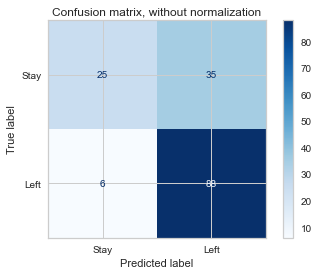

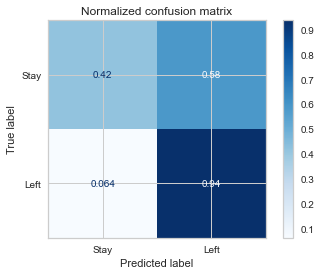

--------------------------------------------------------------------------------
*  ICA  *
--------------------------------------------------------------------------------
Neural Net model fit in 17.184 s
Best Score: 0.893 using {'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'solver': 'lbfgs'}


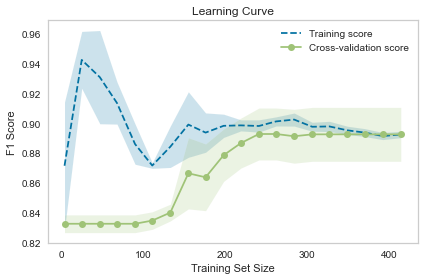

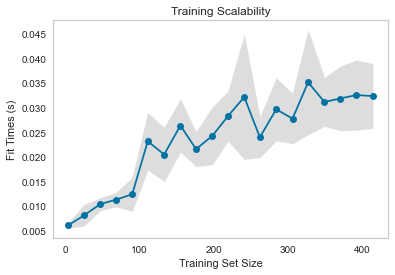

              precision    recall  f1-score   support

           0       0.88      0.38      0.53        60
           1       0.71      0.97      0.82        94

    accuracy                           0.74       154
   macro avg       0.80      0.68      0.68       154
weighted avg       0.78      0.74      0.71       154



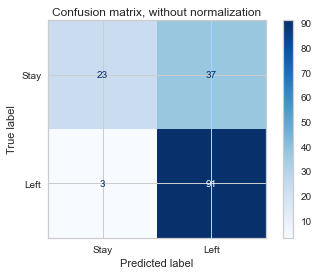

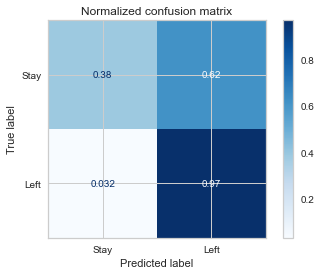

--------------------------------------------------------------------------------
*  RP  *
--------------------------------------------------------------------------------
Neural Net model fit in 30.515 s
Best Score: 0.882 using {'hidden_layer_sizes': (20, 10), 'learning_rate': 'constant', 'solver': 'sgd'}


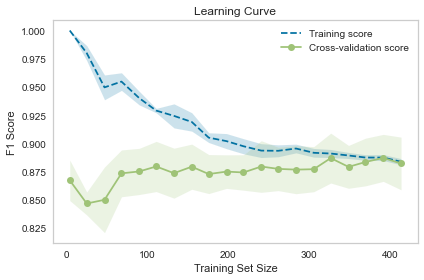

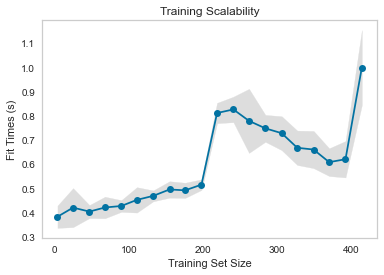

              precision    recall  f1-score   support

           0       0.84      0.35      0.49        60
           1       0.70      0.96      0.81        94

    accuracy                           0.72       154
   macro avg       0.77      0.65      0.65       154
weighted avg       0.75      0.72      0.69       154



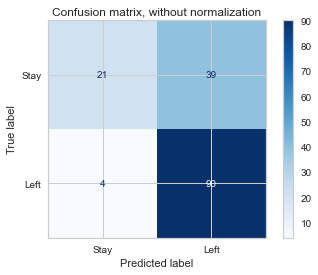

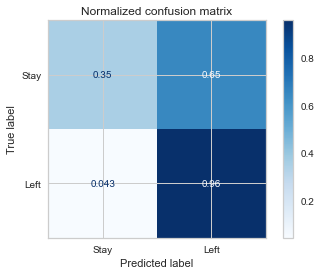

--------------------------------------------------------------------------------
*  UFS  *
--------------------------------------------------------------------------------
Neural Net model fit in 21.920 s
Best Score: 0.894 using {'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'solver': 'sgd'}


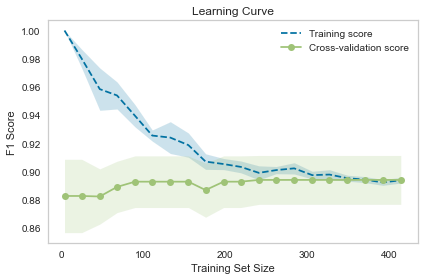

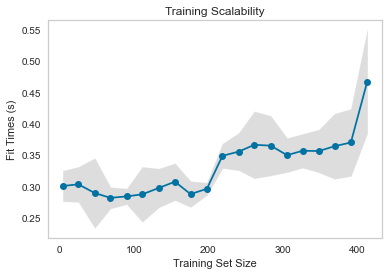

              precision    recall  f1-score   support

           0       0.88      0.38      0.53        60
           1       0.71      0.97      0.82        94

    accuracy                           0.74       154
   macro avg       0.80      0.68      0.68       154
weighted avg       0.78      0.74      0.71       154



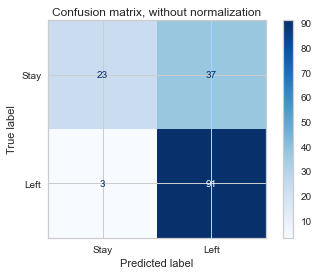

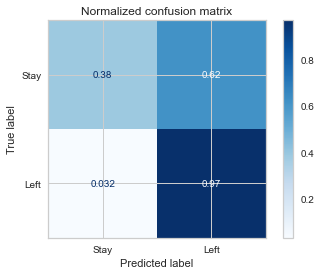

Results
Data:  Original
	Time:    25.921902656555176
	Score:   0.8951731683946974
	Params:  {'hidden_layer_sizes': (40, 20), 'learning_rate': 'constant', 'solver': 'sgd'}
Data:  PCA
	Time:    29.119167804718018
	Score:   0.8937412969645016
	Params:  {'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'solver': 'sgd'}
Data:  ICA
	Time:    17.18405055999756
	Score:   0.8925273925333486
	Params:  {'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
Data:  RP
	Time:    30.515440464019775
	Score:   0.8822658895347095
	Params:  {'hidden_layer_sizes': (20, 10), 'learning_rate': 'constant', 'solver': 'sgd'}
Data:  UFS
	Time:    21.92037534713745
	Score:   0.8940453488458253
	Params:  {'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'solver': 'sgd'}


In [196]:
def calculate_null_accuracy(y):
    vals, counts = np.unique(y, return_counts=True)
    
    norm = counts / np.sum(counts)
    
    return max(norm)

# Define Grid Search parameters
learning_rates = ['constant', 'invscaling']
solvers = ['sgd', 'lbfgs', 'adam']
layers = [(10,), (20,), (40,), (10,10), (20, 10), (20,20), (40,10), (40,20)]
parameters = {'solver': solvers, 'learning_rate': learning_rates, 'hidden_layer_sizes': layers}

# define size of test set
test_size=0.25

# collect all results
nn_data = []

for d in HR_data:
    dataName = d[0]
    print_line(dataName)
    
    X1 = d[1]
    y = y
    
    # Scale the data
    #X = scale(X)
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=test_size, random_state=100)
    
    clf = GridSearchCV(MLPClassifier(max_iter=500, alpha=1, random_state=100),
                       parameters,
                       cv=10,
                       scoring='f1',
                       n_jobs=-1)
                
    t0 = time()
    clf.fit(X_train, y_train)
    nn_time = time() - t0
    
    print("Neural Net model fit in %.3f s" % nn_time)
    print('Best Score: %.3f using %r' % (clf.best_score_, clf.best_params_))
    
    # Create NN with best parameters from grid search
    nn = MLPClassifier(learning_rate=clf.best_params_["learning_rate"],
                       solver=clf.best_params_["solver"],
                       hidden_layer_sizes=clf.best_params_["hidden_layer_sizes"],
                       max_iter=500,
                       alpha=1,
                       random_state=100)
    
    # plot the learning curve for the data
    plot_learning_curve(nn, X_train, y_train)

    # Predict results using the test set
    nn.fit(X_train, y_train)
    nn_pred = nn.predict(X_test)
    
    # Calculate Null Accuracy
    calculate_null_accuracy(y)
    
    # let's see how our model performed
    print(classification_report(y_test, nn_pred))
    
    plot_confusion(nn, X_test, y_test, labels)
    
    
    # Collect results
    results = {
        "classifier": nn,
        "dataset": dataName,
        "time":    nn_time,
        "score":   clf.best_score_,
        "params":  clf.best_params_
    }
    
    nn_data.append(results)

print('Results')
for res in nn_data:
    print('Data: ',     res["dataset"])
    print('\tTime:   ', res["time"])
    print('\tScore:  ', res["score"])
    print('\tParams: ', res["params"])

<div class="alert alert-block alert-warning">
<b>5 NN with Dimensionality Reduction and Clustering Applied to Dataset</b>
</div> </a><a class="anchor" id="encoding"></a>

### K-means

In [197]:
# create dataset

# cluster data and predict labels
kmeans = KMeans(n_clusters=2,init='k-means++', random_state=100)
kmeans.fit(X_scaled)
kmeans_labels = kmeans.predict(X_scaled)

label_diff = (kmeans_labels - y)
label_diff = label_diff[label_diff != 0]
print('Correct Labels: %d/%d, %.2f percent' %(len(y)-len(label_diff), len(y), (len(y)-len(label_diff))/len(y)*100))

# add in cluster labels as additional feature
kmeans_HR_X = np.c_[X_scaled, kmeans_labels]

X_NN = kmeans_HR_X
y = y

Correct Labels: 255/614, 41.53 percent


Neural Net model fit in 28.360 s
Best Score: 0.894 using {'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'sgd'}


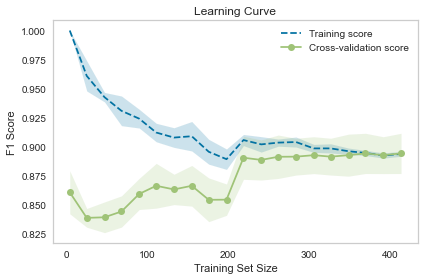

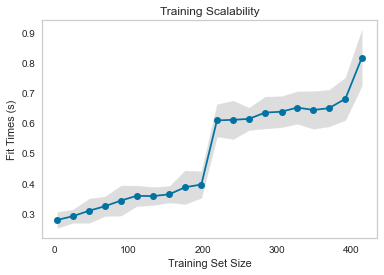

              precision    recall  f1-score   support

           0       0.88      0.38      0.53        60
           1       0.71      0.97      0.82        94

    accuracy                           0.74       154
   macro avg       0.80      0.68      0.68       154
weighted avg       0.78      0.74      0.71       154



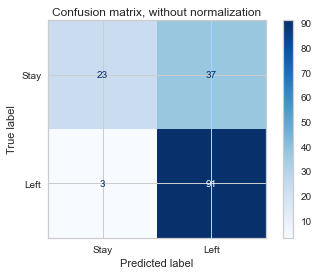

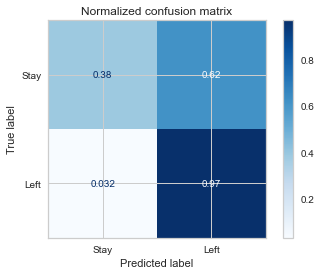

0

In [198]:
# Train Neural net

learning_rates = ['constant', 'invscaling']
solvers = ['sgd', 'lbfgs', 'adam']
layers = [(10,), (20,), (40,), (10,10), (20, 10), (20,20), (40,10), (40,20)]
parameters = {'solver': solvers, 'learning_rate': learning_rates, 'hidden_layer_sizes': layers}



# define size of test set
test_size=0.25


# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_NN, y, test_size=test_size, random_state=100)

clf = GridSearchCV(MLPClassifier(max_iter=500, alpha=1, random_state=100),
                   parameters,
                   cv=10,
                   scoring='f1',
                   n_jobs=-1)
            
t0 = time()
clf.fit(X_train, y_train)
nn_time = time() - t0

print("Neural Net model fit in %.3f s" % nn_time)
print('Best Score: %.3f using %r' % (clf.best_score_, clf.best_params_))

# Create NN with best parameters from grid search
nn = MLPClassifier(learning_rate=clf.best_params_["learning_rate"],
                   solver=clf.best_params_["solver"],
                   hidden_layer_sizes=clf.best_params_["hidden_layer_sizes"],
                   max_iter=500,
                   alpha=1,
                   random_state=100)

# plot the learning curve for the data
plot_learning_curve(nn, X_train, y_train)

# Predict results using the test set
nn.fit(X_train, y_train)
nn_pred = nn.predict(X_test)

# Calculate Null Accuracy
calculate_null_accuracy(y)

# let's see how our model performed
print(classification_report(y_test, nn_pred))

plot_confusion(nn, X_test, y_test, labels)

### Expectation Maximization

In [199]:
# create dataset

# cluster data and predict labels
em = GaussianMixture(n_components=2, random_state=100)
em.fit(X_scaled)
em_labels = em.predict(X_scaled)

label_diff = (em_labels - y)
label_diff = label_diff[label_diff != 0]
print('Correct Labels: %d/%d, %.2f percent' %(len(y)-len(label_diff), len(y), (len(y)-len(label_diff))/len(y)*100))


# add in cluster labels as additional feature
em_HR_X = np.c_[X_scaled, em_labels]

X_NN = em_HR_X
y = y

Correct Labels: 120/614, 19.54 percent


Neural Net model fit in 26.278 s
Best Score: 0.893 using {'hidden_layer_sizes': (20, 10), 'learning_rate': 'constant', 'solver': 'sgd'}


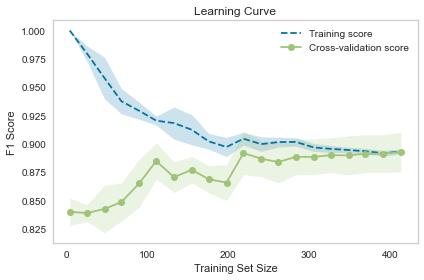

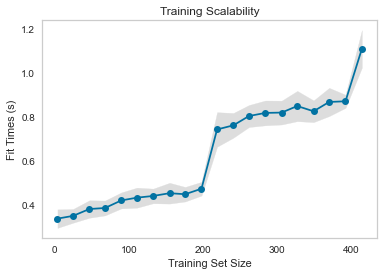

              precision    recall  f1-score   support

           0       0.92      0.38      0.54        60
           1       0.71      0.98      0.83        94

    accuracy                           0.75       154
   macro avg       0.82      0.68      0.68       154
weighted avg       0.79      0.75      0.71       154



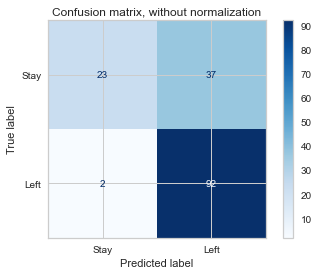

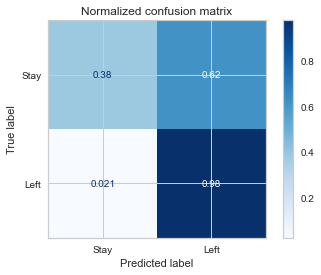

0

In [200]:
# Train Neural net

learning_rates = ['constant', 'invscaling']
solvers = ['sgd', 'lbfgs', 'adam']
layers = [(10,), (20,), (40,), (10,10), (20, 10), (20,20), (40,10), (40,20)]
parameters = {'solver': solvers, 'learning_rate': learning_rates, 'hidden_layer_sizes': layers}


# define size of test set
test_size=0.25


# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_NN, y, test_size=test_size, random_state=100)

clf = GridSearchCV(MLPClassifier(max_iter=500, alpha=1, random_state=100),
                   parameters,
                   cv=10,
                   scoring='f1',
                   n_jobs=-1)
            
t0 = time()
clf.fit(X_train, y_train)
nn_time = time() - t0

print("Neural Net model fit in %.3f s" % nn_time)
print('Best Score: %.3f using %r' % (clf.best_score_, clf.best_params_))

# Create NN with best parameters from grid search
nn = MLPClassifier(learning_rate=clf.best_params_["learning_rate"],
                   solver=clf.best_params_["solver"],
                   hidden_layer_sizes=clf.best_params_["hidden_layer_sizes"],
                   max_iter=500,
                   alpha=1,
                   random_state=100)

# plot the learning curve for the data
plot_learning_curve(nn, X_train, y_train)

# Predict results using the test set
nn.fit(X_train, y_train)
nn_pred = nn.predict(X_test)

# Calculate Null Accuracy
calculate_null_accuracy(y)

# let's see how our model performed
print(classification_report(y_test, nn_pred))

plot_confusion(nn, X_test, y_test, labels)